# Time Series Forecasting

## Downloading Datasets

In [33]:
import kagglehub
import os

# Download latest version
yahoo_path = kagglehub.dataset_download("arashnic/time-series-forecasting-with-yahoo-stock-price")
yahoo_path = os.path.join(yahoo_path, "yahoo_stock.csv")

gold_path = kagglehub.dataset_download("sahilwagh/gold-stock-prices")
gold_path = os.path.join(gold_path, 'goldstock v2.csv')

apple_path = kagglehub.dataset_download("mayankanand2701/apple-stock-price-dataset")
apple_path = os.path.join(apple_path, "Apple Dataset.csv")

store_path = kagglehub.dataset_download("rohitsahoo/sales-forecasting")
store_path = os.path.join(store_path, 'train.csv')

climate_path = kagglehub.dataset_download("sumanthvrao/daily-climate-time-series-data")

print("Climate dataset:", climate_path)
print("Apple Stock dataset:", apple_path)
print("Yahoo stock dataset:", yahoo_path)
print("Gold stock dataset:", gold_path)
print("Path to dataset files:", store_path)


Climate dataset: /kaggle/input/daily-climate-time-series-data
Apple Stock dataset: /kaggle/input/apple-stock-price-dataset/Apple Dataset.csv
Yahoo stock dataset: /kaggle/input/time-series-forecasting-with-yahoo-stock-price/yahoo_stock.csv
Gold stock dataset: /kaggle/input/gold-stock-prices/goldstock v2.csv
Path to dataset files: /kaggle/input/sales-forecasting/train.csv


## Importing Libraries

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
import torch.nn as nn
import joblib
import scipy.stats as st
import warnings
import statsmodels.api as sm

warnings.filterwarnings("ignore")


sns.set_style("whitegrid")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device = ", device)

device =  cpu


## Installing Packages

In [35]:
!pip install statsmodels

## Common Utilties

In [36]:
def iqr_outliers(arr, prop=1.5):
    """
    Identifies and replaces outliers in a specified column of a DataFrame using the IQR method.

    Args:
        arr: Numpy Array.
        prop: proportion of outliers to be removed, default = 1.5

    Returns:
        A DataFrame with outliers replaced by lower and upper bounds.
    """
    Q1 = np.quantile(arr,0.25)
    Q3 = np.quantile(arr,0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - prop * IQR
    upper_bound = Q3 + prop * IQR
    arr = np.where(arr < lower_bound, lower_bound, arr)
    arr = np.where(arr > upper_bound, upper_bound, arr)

    return arr

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_acf_pacf(data):
    """
    Plots the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) for a given time series.

    Args:
        data (numpy.ndarray): A 1D numpy array representing the time series data.
    """
    fig, axes = plt.subplots(2, 1, figsize=(10, 8))
    plot_acf(data, lags=40, ax=axes[0])
    axes[0].set_title("Autocorrelation Function (ACF)")

    plot_pacf(data, lags=40, ax=axes[1])
    axes[1].set_title("Partial Autocorrelation Function (PACF)")

    plt.tight_layout()
    plt.show()

In [37]:
from statsmodels.tsa.stattools import adfuller

def is_stationary(series):
    """
    Performs the Augmented Dickey-Fuller test on a time series and returns True if the series is stationary.

    Args:
        series (numpy.ndarray): A 1D numpy array representing the time series data.

    Returns:
        bool: True if the series is stationary, False otherwise.
    """
    result = adfuller(series)
    p_value = result[1]
    return p_value < 0.05

In [38]:
def plot_losses(model_results, figsize=(12,6)):

    plt.figure(figsize=figsize)
    plt.plot(model_results['epoch'], model_results['train_loss'], label="Train")
    plt.plot(model_results['epoch'], model_results['test_loss'], label="Test")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss curves")
    plt.legend()
    plt.show()

In [8]:
def plot_predictions(original,predictions, figsize=(12,6)):
    plt.figure(figsize=figsize)
    plt.plot(original, label="Original")
    plt.plot(predictions, label="Predicted")
    plt.ylabel("Prediction")
    plt.title("Predictions")
    plt.legend()
    plt.show()

In [39]:
def create_sequences(df, sequence_length, target_length, 
                     features, target_attrs):
    sequences = []
    targets = []
    for i in range(len(df) - sequence_length - target_length + 1):
        sequence = df[features].iloc[i:i + sequence_length]
        target = df[target_attrs].iloc[i + sequence_length:i + sequence_length + target_length]
        sequences.append(sequence)
        targets.append(target)
    return np.array(sequences), np.array(targets)


In [40]:
def lstm_predict(model,prices,scaler = None):
    X = prices.reshape(1,-1)
    X = torch.tensor(X).type(torch.float32).to(device)
    X = X.unsqueeze(2)
    
    model.eval()
    with torch.no_grad():
        y = model(X)

    X = X.squeeze(2)
    if scaler is not None:
        X = scaler.inverse_transform(X.cpu().numpy())
        y = scaler.inverse_transform(y.cpu().numpy())

    return X[0], y[0][0]

def xgb_predict(model, prices, scaler = None):
    X = prices.reshape(1, -1)
    y = model.predict(X).reshape(-1,1)
    
    if scaler is not None:
        X = scaler.inverse_transform(X)
        y = scaler.inverse_transform(y)

    return X[0], y[0][0]


In [41]:
def lstm_training(model: nn.Module,
                  criterion,
                  optimizer,
                  X_train_tensor: torch.Tensor,
                  y_train_tensor: torch.Tensor,
                  X_test_tensor: torch.Tensor,
                  y_test_tensor: torch.Tensor, 
                  batch_size: int, 
                  num_epochs: int) -> pd.DataFrame:
    train_losses = []
    test_losses = []
    
    
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        train_loss = 0
        for i in range(0, len(X_train_tensor), batch_size):
            batch_X = X_train_tensor[i:i+batch_size]
            batch_y = y_train_tensor[i:i+batch_size]

            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= (len(X_train_tensor) / batch_size)
        train_losses.append(train_loss)

    
        model.eval()
        with torch.no_grad():
            test_loss = 0
            for i in range(0, len(X_test_tensor), batch_size):
                batch_X = X_test_tensor[i:i+batch_size]
                batch_y = y_test_tensor[i:i+batch_size]
            
                outputs = model(batch_X)
                test_loss += criterion(outputs, batch_y).item()
            
            
            test_loss /= (len(X_test_tensor) / batch_size)
            test_losses.append(test_loss)

    
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

    results_df = pd.DataFrame({
        'epoch': np.arange(1, num_epochs+1),
        'train_loss': np.array(train_losses),
        'test_loss': np.array(test_losses)
    })

    return results_df

In [42]:

def xgb_train(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    xgb_predictions = model.predict(X_test)
    xgb_train_predictions = model.predict(X_train)

    test_rmse = np.sqrt(mean_squared_error(y_test, xgb_predictions))
    train_rmse = np.sqrt(mean_squared_error(y_train, xgb_train_predictions))
    print(f"Train RMSE: {train_rmse}, Test RMSE: {test_rmse}")
    return xgb_train_predictions, xgb_predictions


In [43]:
def lstm_forecast(model, inputs, scaler=None):
    inputs, out = lstm_predict(model, inputs, scaler)
    plt.plot(np.arange(len(inputs)),inputs, linestyle='dotted', label='input',  marker='o', markersize=5)
    plt.plot(np.arange(len(inputs), len(inputs)+1),out, linestyle='dotted', label='predicted', color='green', marker='o', markersize=5)
    plt.legend()
    plt.title('LSTM Forecasting')
    plt.show()

def xgb_forecast(model, inputs, scaler=None):
    inputs, out = xgb_predict(model, inputs, scaler)
    plt.plot(np.arange(1,len(inputs)+1),inputs, 
             linestyle='dotted', label='input',  
             marker='o', markersize=5)
    plt.plot(np.arange(len(inputs)+1, len(inputs)+2),np.array([out]), 
             linestyle='dotted', label='forecast',
             color='green', marker='o', markersize=5)
    plt.legend()
    plt.title('XGB Forecasting')
    plt.show()


## Yahoo Stock Price Analysis

### Reading Data

In [14]:
yahoo_df = pd.read_csv(yahoo_path, parse_dates=["Date"])
yahoo_df.rename(columns={'Adj Close': 'adj_close'}, inplace=True)
yahoo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1825 non-null   datetime64[ns]
 1   High       1825 non-null   float64       
 2   Low        1825 non-null   float64       
 3   Open       1825 non-null   float64       
 4   Close      1825 non-null   float64       
 5   Volume     1825 non-null   float64       
 6   adj_close  1825 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 99.9 KB


### Data Visualisation

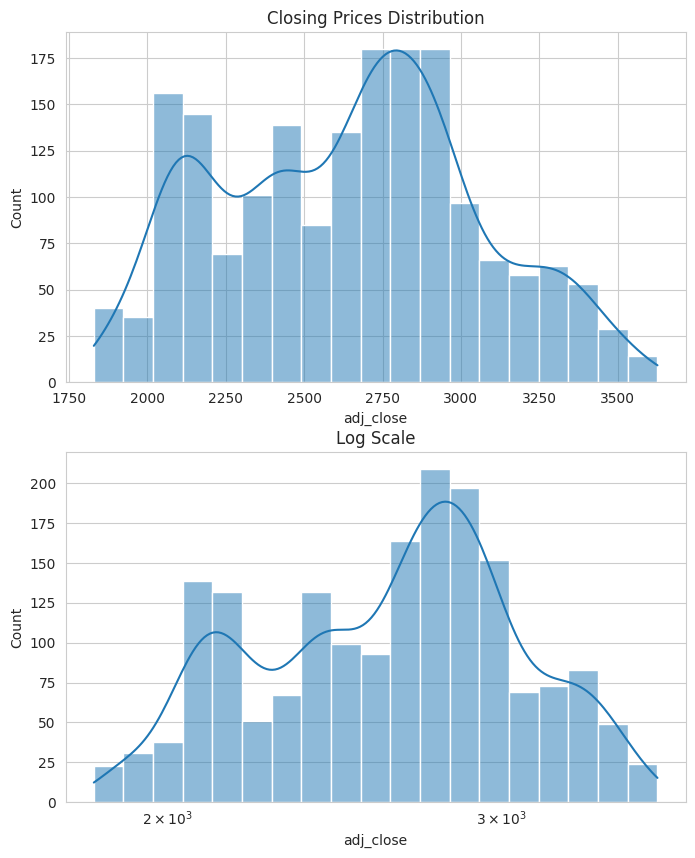

In [15]:
fig, axs = plt.subplots(2, figsize=(8,10))
sns.histplot(data=yahoo_df, x='adj_close', ax=axs[0], kde=True)
axs[0].set_title('Closing Prices Distribution')
sns.histplot(data=yahoo_df, x='adj_close', ax=axs[1], log_scale=True, kde=True)
axs[1].set_title('Log Scale')
plt.show()

There isn't much noticable differences between distribution of closing prices and their log transformations

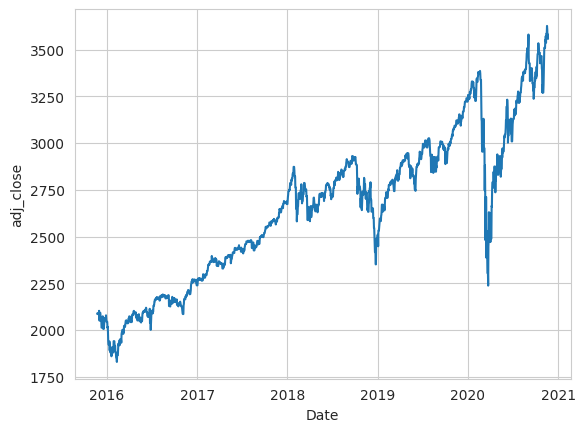

In [16]:
sns.lineplot(data=yahoo_df, x='Date', y='adj_close')
plt.show()

The time series is following an uptrend

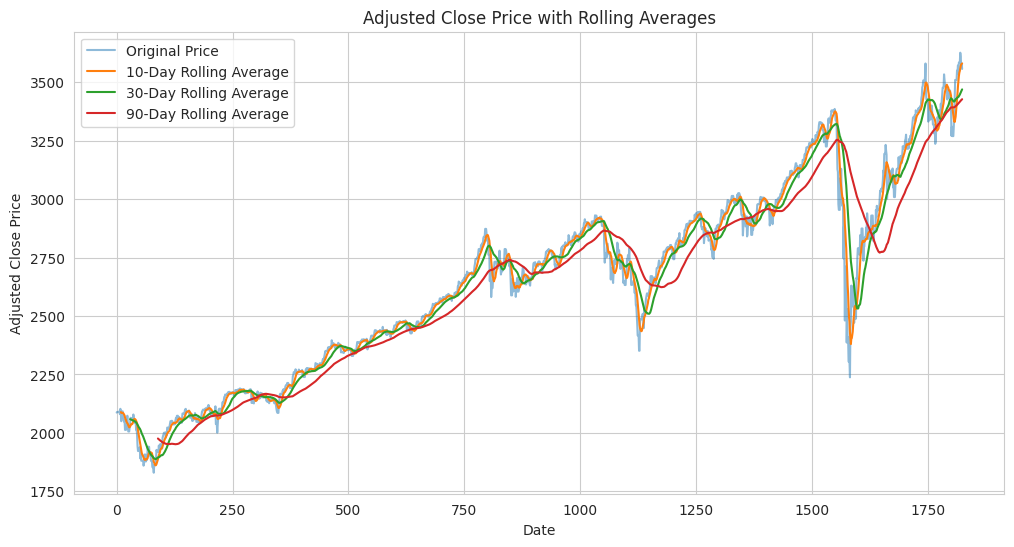

In [17]:
# Calculate rolling averages with different windows
rolling_10d = yahoo_df['adj_close'].rolling(window=10).mean()
rolling_30d = yahoo_df['adj_close'].rolling(window=30).mean()
rolling_90d = yahoo_df['adj_close'].rolling(window=90).mean()

# Plot the rolling averages
plt.figure(figsize=(12, 6))
plt.plot(yahoo_df['adj_close'], label='Original Price', alpha=0.5)
plt.plot(rolling_10d, label='10-Day Rolling Average')
plt.plot(rolling_30d, label='30-Day Rolling Average')
plt.plot(rolling_90d, label='90-Day Rolling Average')
plt.title('Adjusted Close Price with Rolling Averages')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.grid(True)
plt.show()

Now all differences are adjusted with in -100 and 100

### Data Preprocessing

In [43]:
from sklearn.preprocessing import MinMaxScaler
yahoo_scaler = MinMaxScaler(feature_range=(0,1))
yahoo_df['adj_close_scaled'] = yahoo_scaler.fit_transform(
    yahoo_df[['adj_close']]
)

Normalised differences using standard scaler and actual prices using min_max scaler to preserve the trend

In [44]:

seq_length = 10
forecast_length = 1
target_attrs = ['adj_close_scaled']
features = ['adj_close_scaled']
X, y = create_sequences(yahoo_df, seq_length, forecast_length,features, target_attrs)

y = np.squeeze(y, 1)

X_train, y_train = X[:int(0.8 * len(X))], y[:int(0.8 * len(y))]
X_test, y_test = X[int(0.8 * len(X)):], y[int(0.8 * len(y)):]

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)
print(X_train_tensor.shape, y_train_tensor.shape, X_test_tensor.shape, y_test_tensor.shape)


X_train shape: (1452, 10, 1)
y_train shape: (1452, 1)
X_test shape: (363, 10, 1)
y_test shape: (363, 1)
torch.Size([1452, 10, 1]) torch.Size([1452, 1]) torch.Size([363, 10, 1]) torch.Size([363, 1])


### Model building


#### LSTM Model

In [45]:

class YahooLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(YahooLSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size,
                            hidden_size,
                            num_layers,
                            batch_first=True)

        self.fc = nn.Sequential(
              nn.ReLU(),
              nn.Linear(hidden_size, output_size),
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out


In [46]:
input_size = 1
hidden_size = 10
num_layers = 1
output_size = 1

yahoo_lstm_model = YahooLSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(yahoo_lstm_model.parameters(), lr=0.001)

yahoo_lstm_model

YahooLSTMModel(
  (lstm): LSTM(1, 10, batch_first=True)
  (fc): Sequential(
    (0): ReLU()
    (1): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [47]:
# Training the model
yahoo_lstm_results = lstm_training(
                yahoo_lstm_model,
                criterion,
                optimizer,
                X_train_tensor,
                y_train_tensor,
                X_test_tensor,
                y_test_tensor,
                batch_size=16,
                num_epochs=500
        )


Epoch [1/500], Loss: 0.2082, Test Loss: 0.3034
Epoch [2/500], Loss: 0.0424, Test Loss: 0.1801
Epoch [3/500], Loss: 0.0531, Test Loss: 0.2359
Epoch [4/500], Loss: 0.0440, Test Loss: 0.1685
Epoch [5/500], Loss: 0.0550, Test Loss: 0.2273
Epoch [6/500], Loss: 0.0357, Test Loss: 0.1310
Epoch [7/500], Loss: 0.0629, Test Loss: 0.2438
Epoch [8/500], Loss: 0.0265, Test Loss: 0.0954
Epoch [9/500], Loss: 0.0684, Test Loss: 0.2833
Epoch [10/500], Loss: 0.0172, Test Loss: 0.0219
Epoch [11/500], Loss: 0.1638, Test Loss: 0.5067
Epoch [12/500], Loss: 0.1116, Test Loss: 0.2118
Epoch [13/500], Loss: 0.0288, Test Loss: 0.1470
Epoch [14/500], Loss: 0.0295, Test Loss: 0.1443
Epoch [15/500], Loss: 0.0254, Test Loss: 0.1204
Epoch [16/500], Loss: 0.0205, Test Loss: 0.0976
Epoch [17/500], Loss: 0.0110, Test Loss: 0.0609
Epoch [18/500], Loss: 0.0103, Test Loss: 0.0444
Epoch [19/500], Loss: 0.0092, Test Loss: 0.0738
Epoch [20/500], Loss: 0.0101, Test Loss: 0.0235
Epoch [21/500], Loss: 0.0589, Test Loss: 0.2275
E

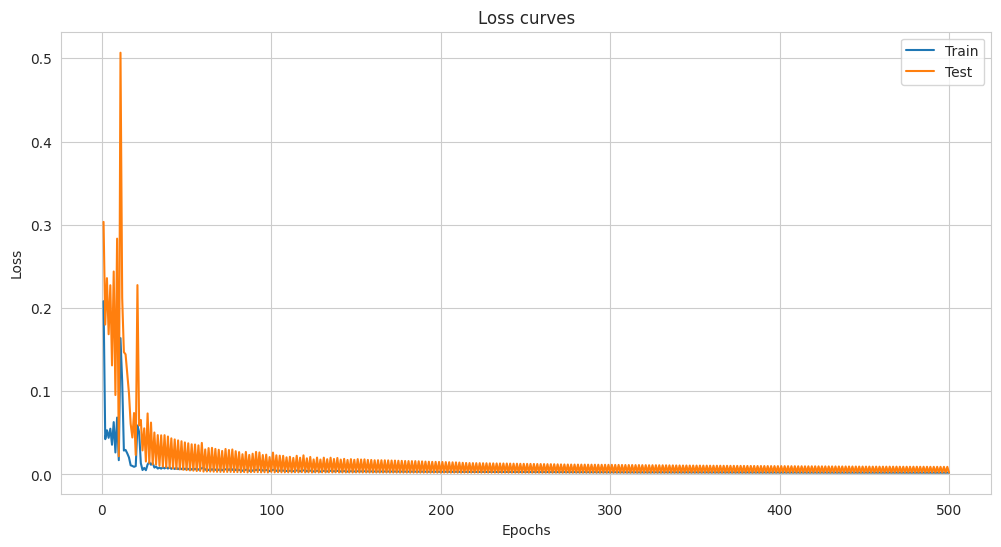

In [48]:
plot_losses(yahoo_lstm_results, figsize=(12,6))

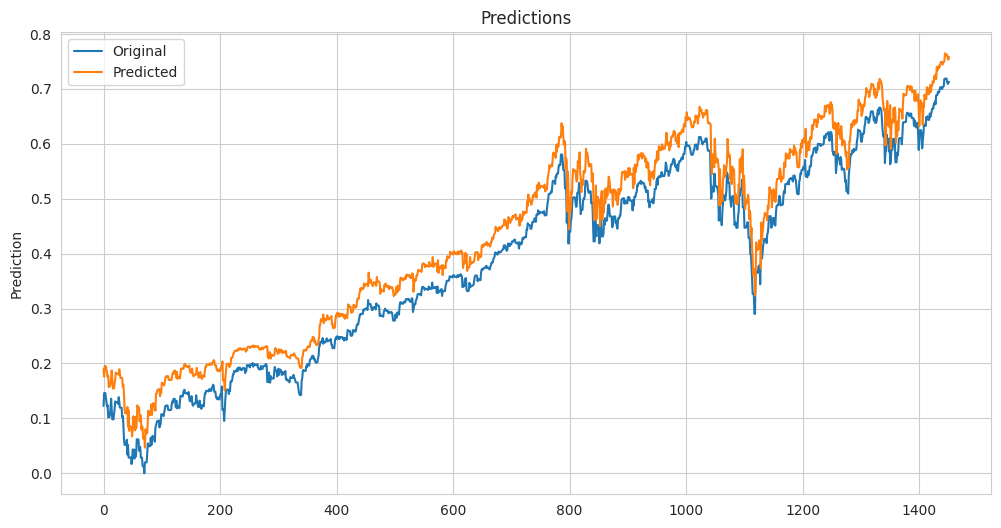

In [49]:
yahoo_lstm_model.eval()

with torch.no_grad():
    predicted = yahoo_lstm_model(X_train_tensor)

plot_predictions(y_train, predicted.cpu().numpy(), figsize=(12,6))


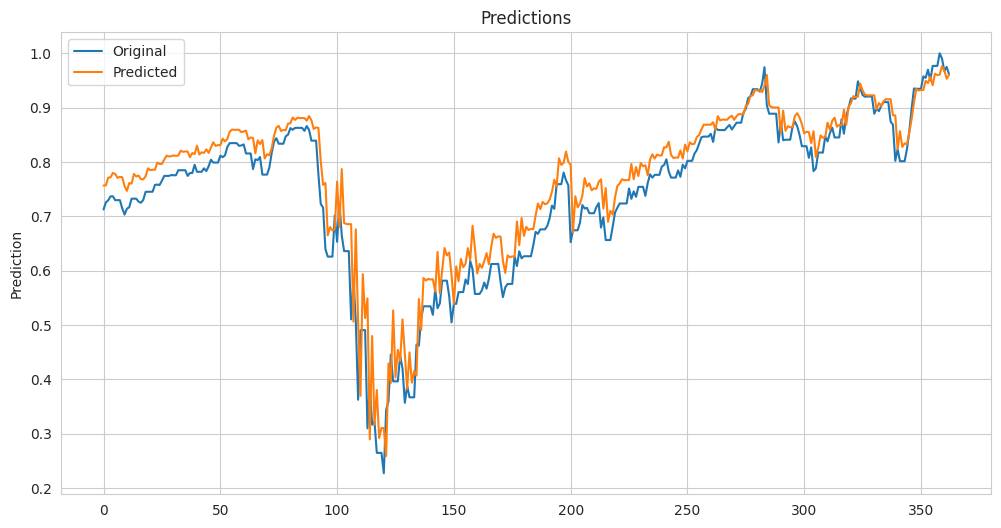

In [50]:
yahoo_lstm_model.eval()
with torch.no_grad():
      predicted = yahoo_lstm_model(X_test_tensor)
    
plot_predictions(y_test, predicted.cpu().numpy(), figsize=(12,6))


#### XGBoost Model

In [59]:

import xgboost as xgb
from sklearn.metrics import mean_squared_error

yahoo_xgb_model = xgb.XGBRegressor(n_estimators=300, objective='reg:squarederror')  
X_train_xgb = X_train.reshape(X_train.shape[0], -1)
X_test_xgb = X_test.reshape(X_test.shape[0], -1)

print(X_train_xgb.shape, X_test_xgb.shape)
xgb_train_preds, xgb_test_preds = xgb_train(yahoo_xgb_model, 
                                            X_train_xgb, y_train, 
                                            X_test_xgb, y_test)

(1452, 10) (363, 10)
Train RMSE: 0.002074490021161496, Test RMSE: 0.11294725679636114


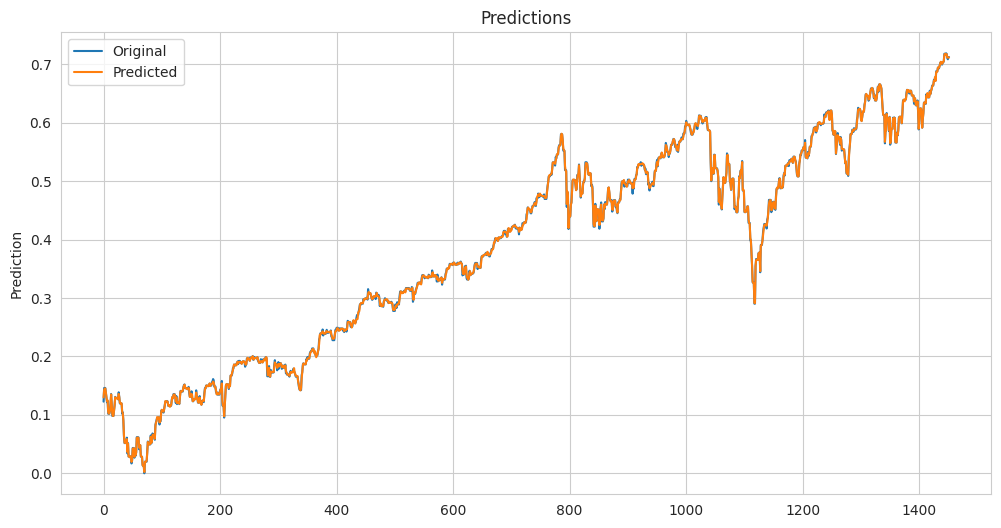

In [52]:
plot_predictions(y_train, xgb_train_preds)

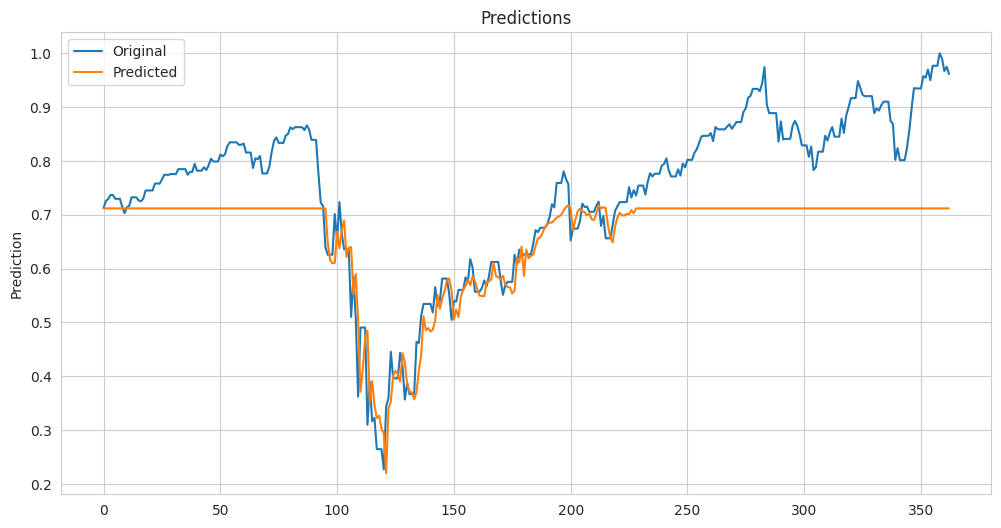

In [53]:
plot_predictions(y_test, xgb_test_preds)

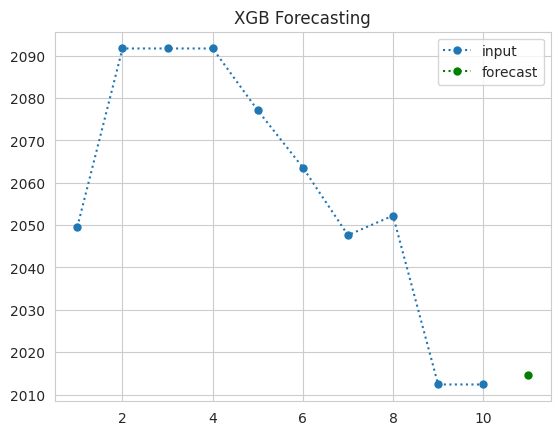

In [60]:
# make predictions
prices = yahoo_df['adj_close_scaled'].iloc[10:20].to_numpy()
lstm_forecast(yahoo_lstm_model, prices, yahoo_scaler)
xgb_forecast(yahoo_xgb_model, prices, yahoo_scaler)


In [55]:
lstm_predict(yahoo_lstm_model, prices, yahoo_scaler)

(array([2049.62, 2091.69, 2091.69, 2091.69, 2077.07, 2063.59, 2047.62,
        2052.23, 2012.37, 2012.37], dtype=float32),
 2115.3752)

In [56]:
# save the model
torch.save(yahoo_lstm_model.state_dict(), "yahoo_lstm_model.pth")
joblib.dump(yahoo_xgb_model,"yahoo_xgb_model.joblib")
joblib.dump(yahoo_scaler, "yahoo_scaler.joblib")
yahoo_lstm_results.to_csv('yahoo_lstm_results.csv', index=False)



## Gold ETF Price Analysis

### Reading The data

In [61]:
gold_df = pd.read_csv(gold_path, parse_dates=['Date'])
gold_df.drop(columns=['Unnamed: 0'], inplace=True)
gold_df.rename(columns={'Close/Last': 'Close'}, inplace=True)
gold_df = gold_df[::-1].reset_index().drop(columns=['index'])
gold_df.head()

Date   Close    Volume    Open    High     Low
0 2014-07-07  1317.0   79110.0  1321.4  1321.7  1312.1
1 2014-07-08  1316.5  126706.0  1320.8  1325.7  1314.3
2 2014-07-09  1324.3  155101.0  1320.4  1333.4  1318.7
3 2014-07-10  1339.2  167391.0  1325.0  1346.8  1325.0
4 2014-07-11  1337.4   88470.0  1336.5  1340.4  1334.6

In [62]:
gold_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2511 entries, 0 to 2510
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2511 non-null   datetime64[ns]
 1   Close   2511 non-null   float64       
 2   Volume  2511 non-null   float64       
 3   Open    2511 non-null   float64       
 4   High    2511 non-null   float64       
 5   Low     2511 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 117.8 KB


### Data Visualisation

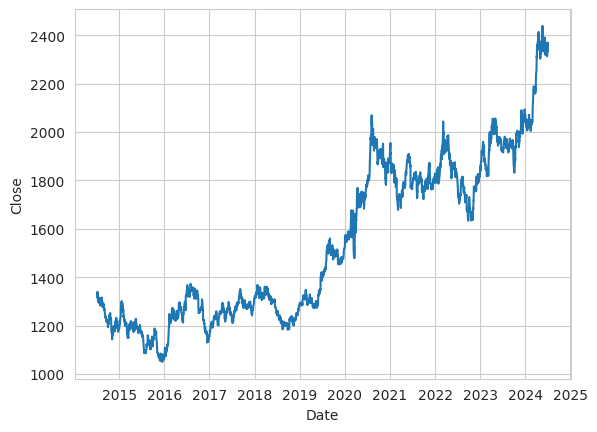

In [63]:
sns.lineplot(data=gold_df, x='Date', y='Close')
plt.show()

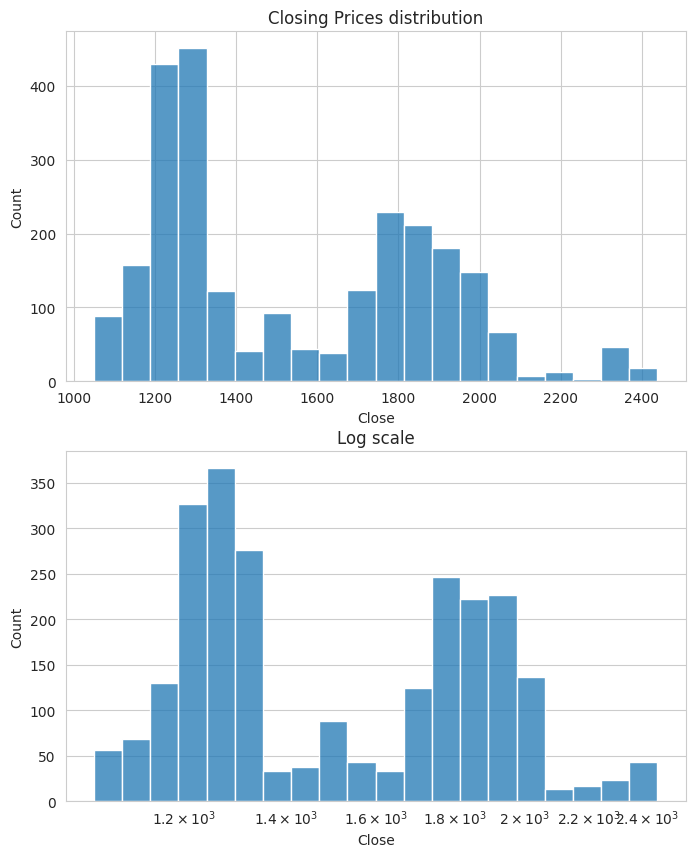

In [64]:
fig,axs = plt.subplots(2, figsize=(8,10))

sns.histplot(data=gold_df, x='Close', bins=20, ax=axs[0])
sns.histplot(data=gold_df, x='Close', bins=20, log_scale=True, ax=axs[1])
axs[0].set_title("Closing Prices distribution")
axs[1].set_title('Log scale')
plt.show()

There isn't much noticable difference in log transformation

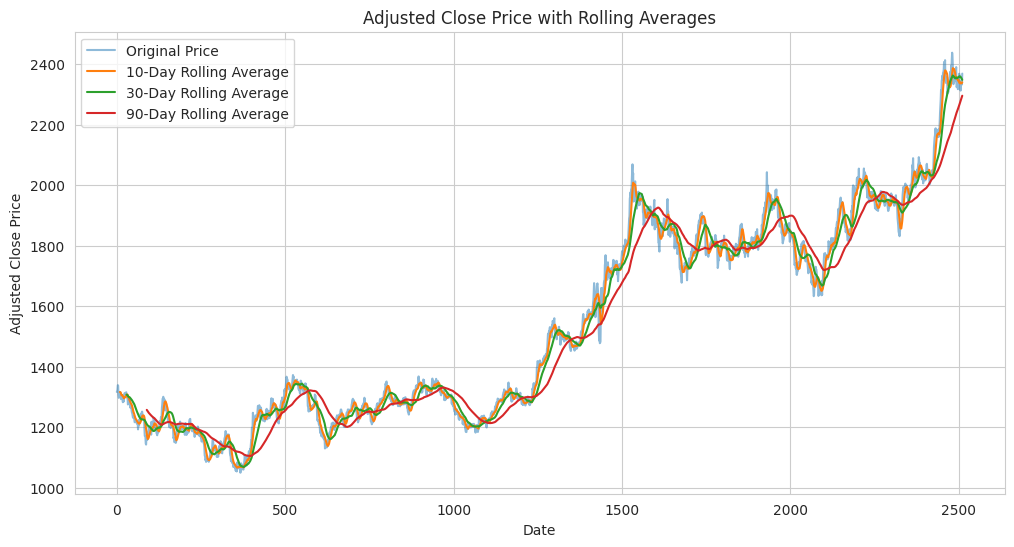

In [65]:
# Calculate rolling averages with different windows
rolling_10d = gold_df['Close'].rolling(window=10).mean()
rolling_30d = gold_df['Close'].rolling(window=30).mean()
rolling_90d = gold_df['Close'].rolling(window=90).mean()

# Plot the rolling averages
plt.figure(figsize=(12, 6))
plt.plot(gold_df['Close'], label='Original Price', alpha=0.5)
plt.plot(rolling_10d, label='10-Day Rolling Average')
plt.plot(rolling_30d, label='30-Day Rolling Average')
plt.plot(rolling_90d, label='90-Day Rolling Average')
plt.title('Adjusted Close Price with Rolling Averages')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.grid(True)
plt.show()

10-day rolling averages, perfectly approximating the series, we are choosing the 10 as the sequence number

### Data Preprocessing

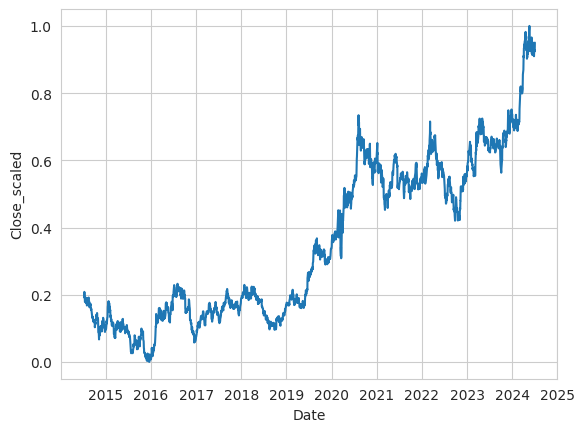

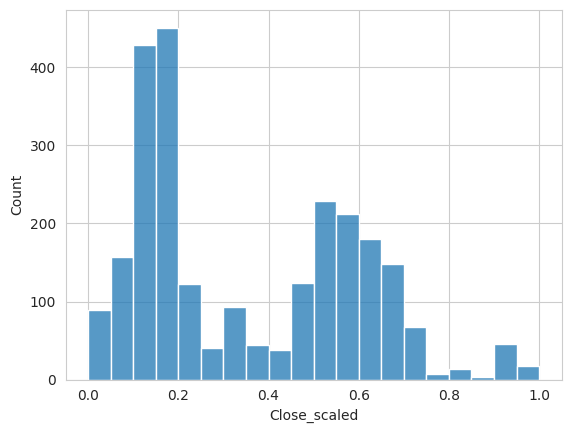

In [96]:
from sklearn.preprocessing import MinMaxScaler

gold_scaler = MinMaxScaler(feature_range=(0,1))
gold_df['Close_scaled'] = gold_scaler.fit_transform(gold_df[['Close']])

sns.lineplot(data=gold_df, x='Date', y='Close_scaled')
plt.show()
sns.histplot(data=gold_df, x='Close_scaled', bins=20)
plt.show()

In [97]:
seq_length = 10
forecast_length = 1
target = ['Close_scaled']
features = ['Close_scaled']
X, y = create_sequences(gold_df, seq_length, 1, target, features)

y = np.squeeze(y, 1)
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (2501, 10, 1)
Shape of y: (2501, 1)


In [98]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.35,
                                                    random_state=42,
                                                    shuffle=False)

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

print("Shape of X_train_tensor:", X_train_tensor.shape)
print("Shape of y_train_tensor:", y_train_tensor.shape)
print("Shape of X_test_tensor:", X_test_tensor.shape)
print("Shape of y_test_tensor:", y_test_tensor.shape)

Shape of X_train: (1625, 10, 1)
Shape of y_train: (1625, 1)
Shape of X_test: (876, 10, 1)
Shape of y_test: (876, 1)
Shape of X_train_tensor: torch.Size([1625, 10, 1])
Shape of y_train_tensor: torch.Size([1625, 1])
Shape of X_test_tensor: torch.Size([876, 10, 1])
Shape of y_test_tensor: torch.Size([876, 1])


### Model Building

#### LSTM Model

In [99]:
class GoldLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super(GoldLSTMModel, self).__init__()

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout)
        self.fc = nn.Sequential(
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out



In [101]:
# Define hyperparameters

input_size = 1 
hidden_size = 10
num_layers = 1
output_size = 1
learning_rate = 0.001
num_epochs = 700
batch_size = 16
dropout = 0

gold_lstm_model = GoldLSTMModel(input_size, hidden_size,
                            num_layers, output_size, dropout).to(device)
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(gold_lstm_model.parameters(), lr=learning_rate)


In [120]:
gold_lstm_results = lstm_training(gold_lstm_model,criterion, 
                                  optimizer,X_train_tensor, 
                                  y_train_tensor, X_test_tensor, 
                                  y_test_tensor,batch_size,num_epochs)

Epoch [1/200], Loss: 0.0013, Test Loss: 0.0005
Epoch [2/200], Loss: 0.0003, Test Loss: 0.0006
Epoch [3/200], Loss: 0.0018, Test Loss: 0.0005
Epoch [4/200], Loss: 0.0005, Test Loss: 0.0003
Epoch [5/200], Loss: 0.0011, Test Loss: 0.0010
Epoch [6/200], Loss: 0.0016, Test Loss: 0.0003
Epoch [7/200], Loss: 0.0006, Test Loss: 0.0004
Epoch [8/200], Loss: 0.0012, Test Loss: 0.0003
Epoch [9/200], Loss: 0.0003, Test Loss: 0.0010
Epoch [10/200], Loss: 0.0024, Test Loss: 0.0005
Epoch [11/200], Loss: 0.0002, Test Loss: 0.0003
Epoch [12/200], Loss: 0.0012, Test Loss: 0.0008
Epoch [13/200], Loss: 0.0009, Test Loss: 0.0003
Epoch [14/200], Loss: 0.0010, Test Loss: 0.0004
Epoch [15/200], Loss: 0.0009, Test Loss: 0.0002
Epoch [16/200], Loss: 0.0005, Test Loss: 0.0011
Epoch [17/200], Loss: 0.0021, Test Loss: 0.0004
Epoch [18/200], Loss: 0.0002, Test Loss: 0.0003
Epoch [19/200], Loss: 0.0014, Test Loss: 0.0005
Epoch [20/200], Loss: 0.0003, Test Loss: 0.0006
Epoch [21/200], Loss: 0.0019, Test Loss: 0.0005
E

In [119]:
# gold_lstm_results = pd.concat((gold_lstm_results_copy,gold_lstm_results)).reset_index().drop(columns=['epoch']).rename(columns={'index': 'epoch'})

gold_lstm_results_copy = gold_lstm_results.copy(deep=True)

#### Loss Curves

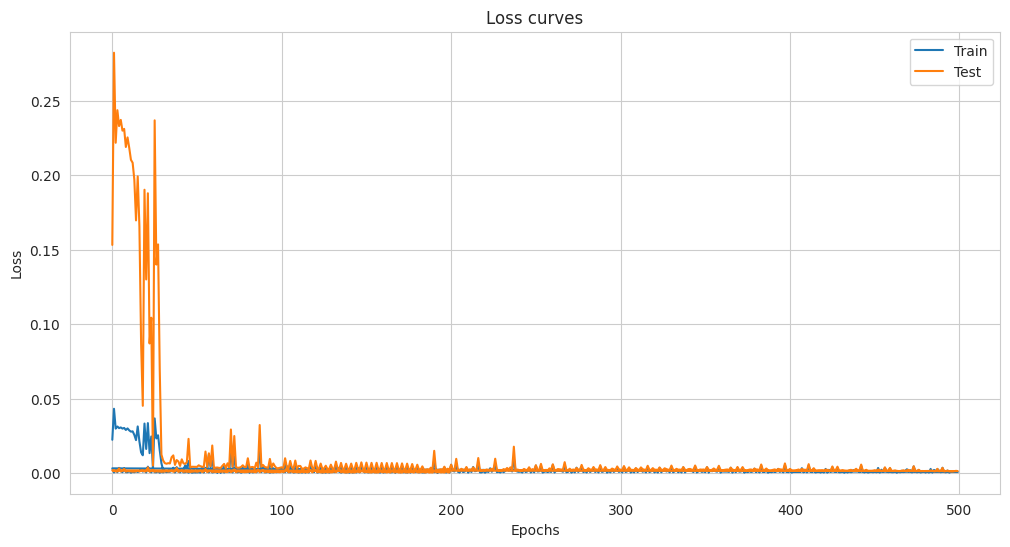

In [118]:
plot_losses(gold_lstm_results)

#### Plot Predictions

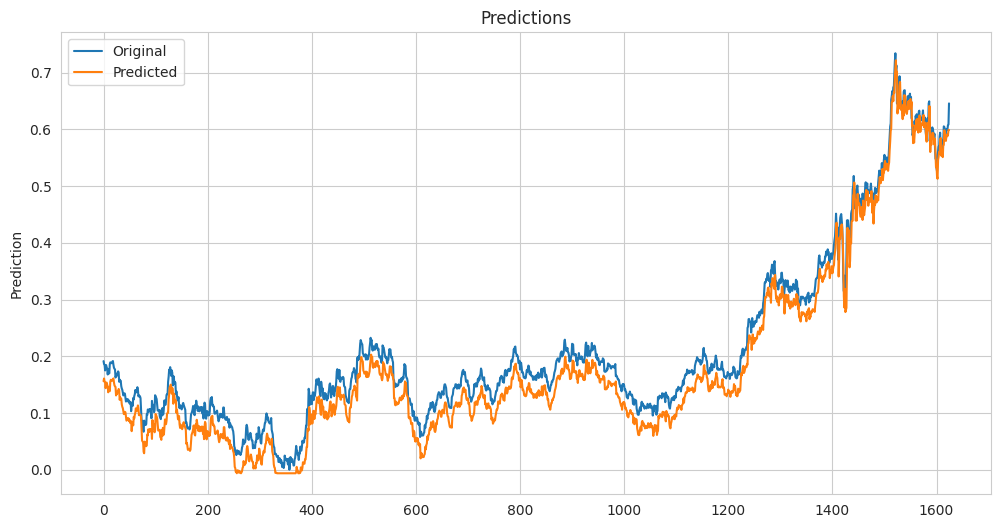

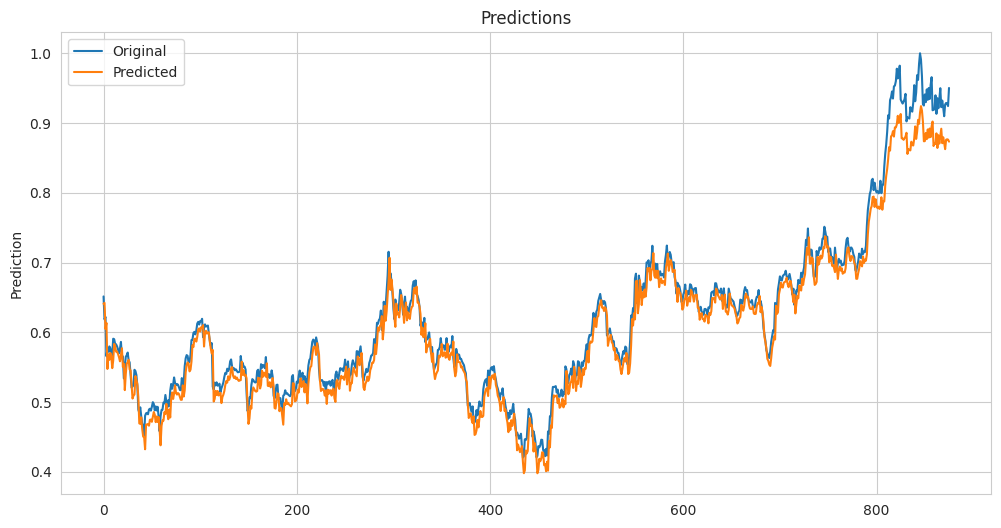

In [121]:

gold_lstm_model.eval()

with torch.no_grad():
    train_predictions = gold_lstm_model(X_train_tensor)
    test_predictions = gold_lstm_model(X_test_tensor)
    

plot_predictions(y_train, train_predictions)
plot_predictions(y_test, test_predictions.cpu().numpy())


#### XGBoost Model

In [108]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Reshape the data for XGBoost
X_train_xgb = X_train.reshape(X_train.shape[0], -1)
X_test_xgb = X_test.reshape(X_test.shape[0], -1)

# Create and train the XGBoost regressor
gold_xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000)

gold_train_preds,gold_test_preds = xgb_train(gold_xgb_model, 
                                            X_train_xgb, y_train,
                                            X_test_xgb, y_test)


Train RMSE: 0.0020056042479657693, Test RMSE: 0.07896961463553574


#### XGBoost predictions

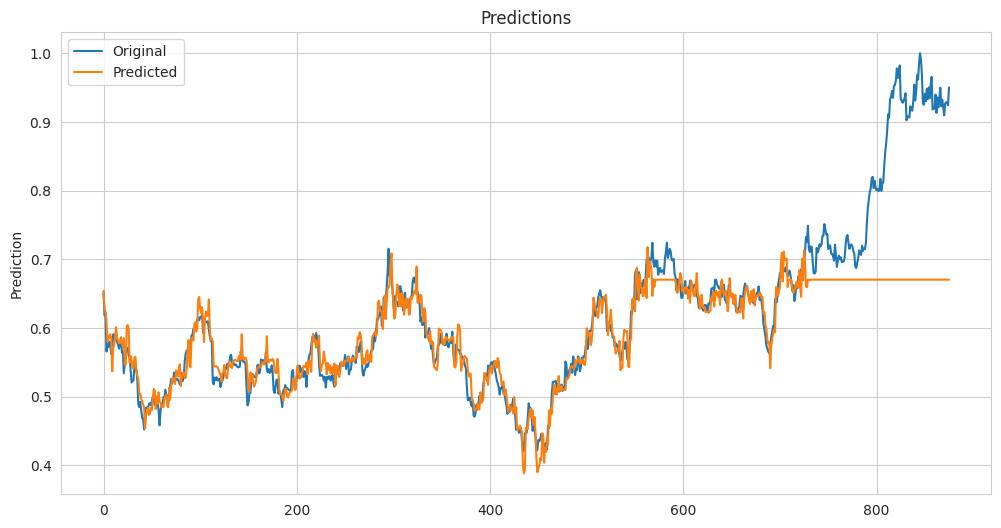

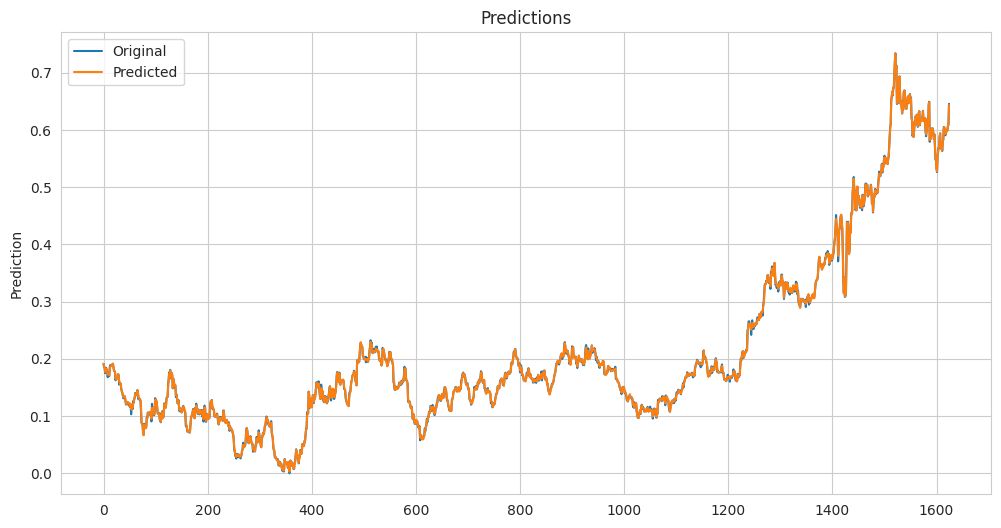

In [109]:
plot_predictions(y_test, gold_test_preds)
plot_predictions(y_train, gold_train_preds)

In [128]:
gold_df['Close'].iloc[10:20].to_numpy()

array([1315.5, 1308. , 1306.5, 1292.7, 1305.3, 1305.8, 1300.5, 1296.9,
       1282.8, 1294.8])

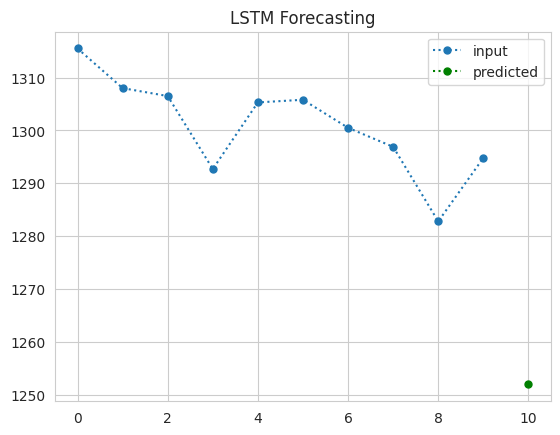

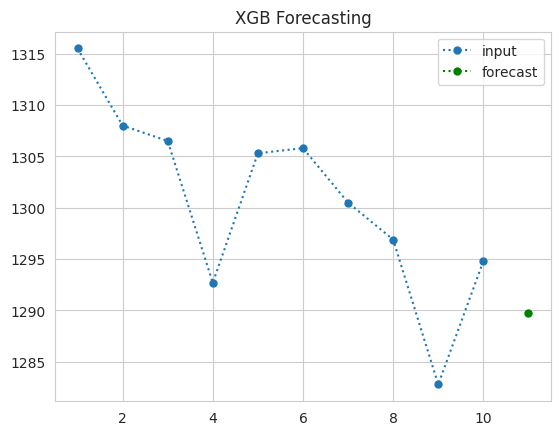

In [129]:
lstm_forecast(gold_lstm_model, 
                   gold_df['Close_scaled'].iloc[10:20].to_numpy(), gold_scaler)
xgb_forecast(gold_xgb_model, 
                  gold_df['Close_scaled'].iloc[10:20].to_numpy(), gold_scaler)

#### Saving the results

In [111]:
torch.save(gold_lstm_model.state_dict(), 'gold_lstm_model.pth')
joblib.dump(gold_scaler, 'gold_scaler.joblib')
joblib.dump(gold_xgb_model, 'gold_xgb_model.joblib')
gold_lstm_results.to_csv('gold_lstm_results.csv')

## Apple Stock Analysis

### Reading the Appple Data

In [15]:
apple_df = pd.read_csv(apple_path, parse_dates=['Date'])
apple_df.rename(columns={'Adj Close': 'adj_close'}, inplace=True)
apple_df.head()

Date      Open      High       Low     Close  adj_close     Volume
0 1980-12-12  0.128348  0.128906  0.128348  0.128348   0.099058  469033600
1 1980-12-15  0.122210  0.122210  0.121652  0.121652   0.093890  175884800
2 1980-12-16  0.113281  0.113281  0.112723  0.112723   0.086999  105728000
3 1980-12-17  0.115513  0.116071  0.115513  0.115513   0.089152   86441600
4 1980-12-18  0.118862  0.119420  0.118862  0.118862   0.091737   73449600

In [16]:
apple_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10954 entries, 0 to 10953
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       10954 non-null  datetime64[ns]
 1   Open       10954 non-null  float64       
 2   High       10954 non-null  float64       
 3   Low        10954 non-null  float64       
 4   Close      10954 non-null  float64       
 5   adj_close  10954 non-null  float64       
 6   Volume     10954 non-null  int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 599.2 KB


### Data Visualisation

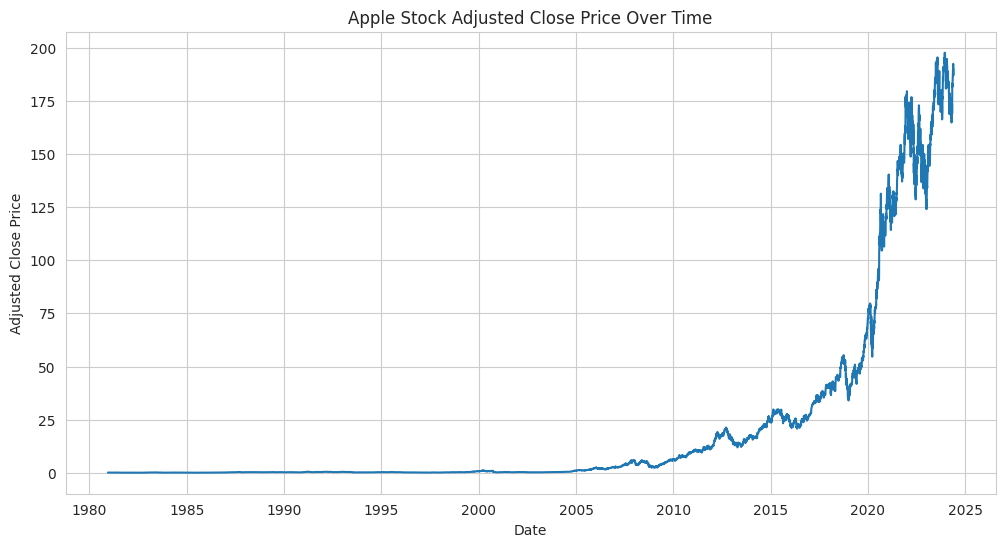

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(apple_df['Date'], apple_df['adj_close'])
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.title('Apple Stock Adjusted Close Price Over Time')
plt.grid(True)
plt.show()

As actual trend started from 2010, we are starting analysis from 2010

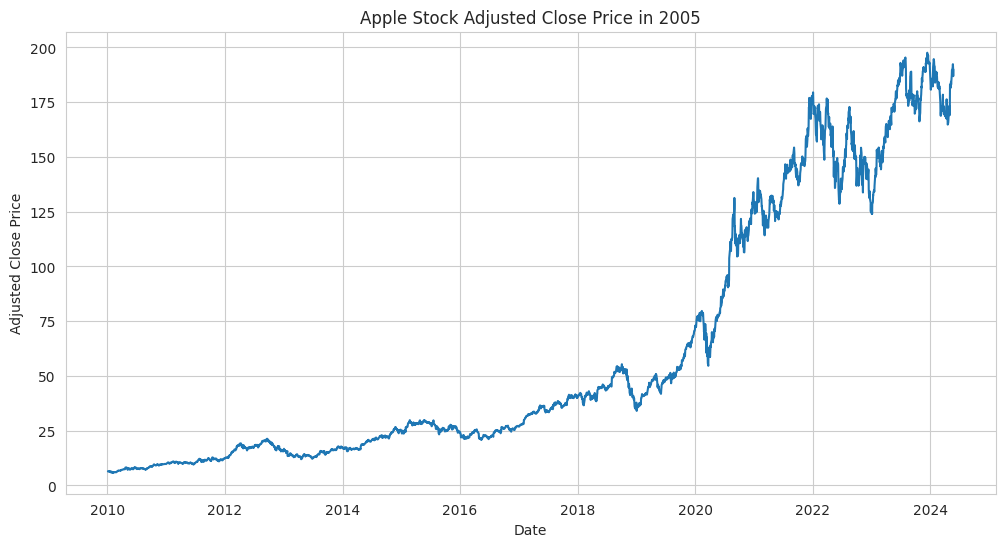

In [18]:
apple_df_2010 = apple_df[apple_df['Date'].dt.year >= 2010]

plt.figure(figsize=(12, 6))
plt.plot(apple_df_2010['Date'], apple_df_2010['adj_close'])
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.title('Apple Stock Adjusted Close Price in 2005')
plt.grid(True)
plt.show()

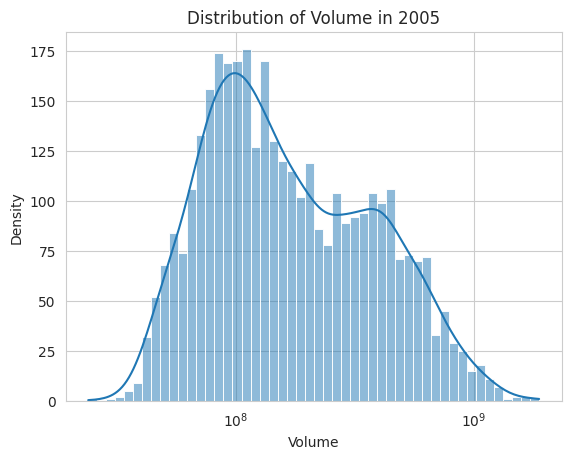

In [19]:
sns.histplot(apple_df_2010['Volume'], kde=True, log_scale=True, bins=50)
plt.xlabel('Volume')
plt.ylabel('Density')
plt.title('Distribution of Volume in 2005')
plt.show()

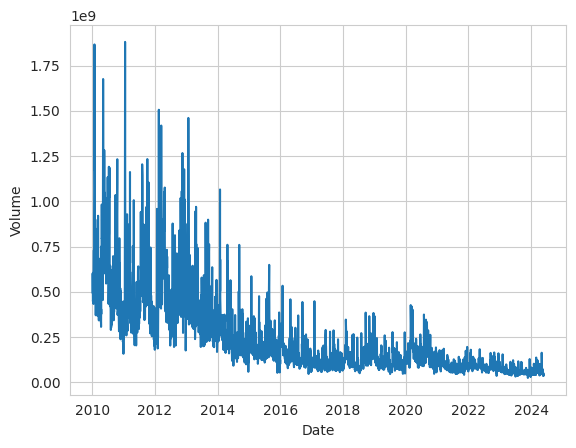

In [20]:
sns.lineplot(data=apple_df_2010, x='Date', y='Volume')
plt.show()

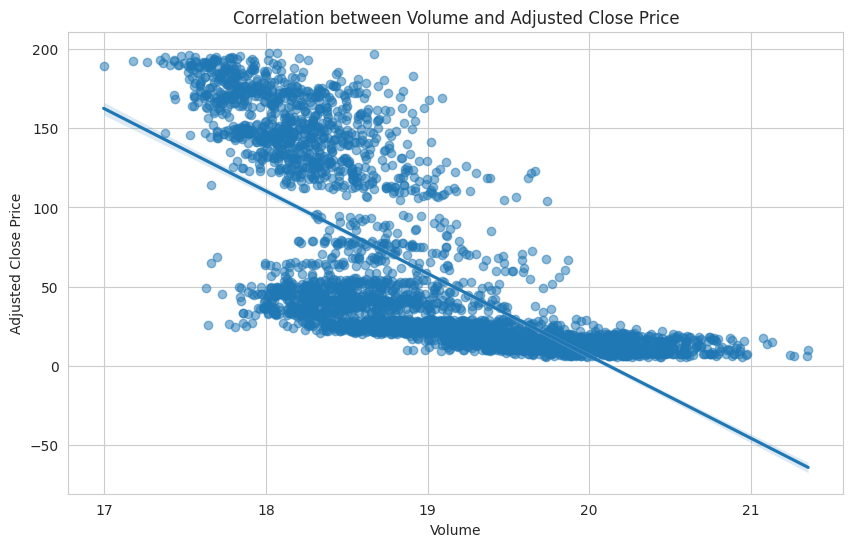

Correlation coefficient: -0.7127957739023246


In [21]:
plt.figure(figsize=(10, 6))
sns.regplot(x=np.log(apple_df_2010['Volume']),
            y=apple_df_2010['adj_close'], 
            scatter_kws={'alpha': 0.5})
plt.xlabel('Volume')
plt.ylabel('Adjusted Close Price')
plt.title('Correlation between Volume and Adjusted Close Price')
plt.grid(True)
plt.show()

correlation = np.log(apple_df_2010['Volume']).corr(apple_df_2010['adj_close'])
print(f"Correlation coefficient: {correlation}")

**There is a negative correlation between closing price and traded volumes**

In [22]:
apple_df_2010.loc[:, 'volume_log'] = apple_df_2010['Volume'].apply(np.log)
apple_df_2010.head()

Date      Open      High       Low     Close  adj_close     Volume  \
7331 2010-01-04  7.622500  7.660714  7.585000  7.643214   6.461977  493729600   
7332 2010-01-05  7.664286  7.699643  7.616071  7.656429   6.473148  601904800   
7333 2010-01-06  7.656429  7.686786  7.526786  7.534643   6.370185  552160000   
7334 2010-01-07  7.562500  7.571429  7.466071  7.520714   6.358409  477131200   
7335 2010-01-08  7.510714  7.571429  7.466429  7.570714   6.400681  447610800   

      volume_log  
7331   20.017499  
7332   20.215610  
7333   20.129348  
7334   19.983302  
7335   19.919435

In [23]:
apple_data = apple_df_2010[['adj_close', 'volume_log']]
apple_data.head()

adj_close  volume_log
7331   6.461977   20.017499
7332   6.473148   20.215610
7333   6.370185   20.129348
7334   6.358409   19.983302
7335   6.400681   19.919435

### Data Preprocessing

In [24]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Min-Max scaling for 'adj_close'
apple_close_scaler = MinMaxScaler(feature_range=(1,10))
apple_data.loc[:,'adj_close_scaled'] = apple_close_scaler.fit_transform(
    apple_data[['adj_close']]
)

# Standard scaling for 'volume_log'
apple_volume_scaler = StandardScaler()
apple_data.loc[:, 'volume_log_scaled'] = apple_volume_scaler.fit_transform(
    apple_data[['volume_log']]
)

apple_data.describe()

adj_close   volume_log  adj_close_scaled  volume_log_scaled
count  3623.000000  3623.000000       3623.000000       3.623000e+03
mean     61.161672    18.946443          3.597963      -6.275840e-17
std      58.483725     0.802383          2.744417       1.000138e+00
min       5.798900    16.995575          1.000000      -2.431678e+00
25%      17.218267    18.305555          1.535867      -7.988412e-01
50%      32.590687    18.803491          2.257236      -1.781839e-01
75%     114.391723    19.584429          6.095846       7.952233e-01
max     197.589523    21.355068         10.000000       3.002254e+00

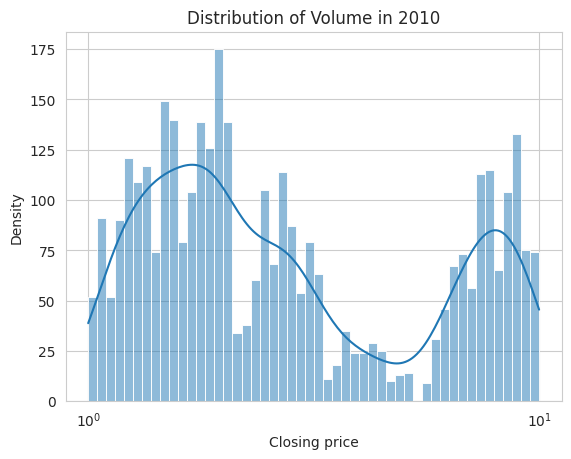

In [25]:
sns.histplot(apple_data['adj_close_scaled'], kde=True, 
             log_scale=True, bins=50)
plt.xlabel('Closing price')
plt.ylabel('Density')
plt.title('Distribution of Volume in 2010')
plt.show()

In [26]:
seq_length = 10
X, y = create_sequences(apple_data, seq_length, 1, 
                        ['adj_close_scaled'], 
                        ['adj_close_scaled'])
y = np.squeeze(y, 1)
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (3613, 10, 1)
Shape of y: (3613, 1)


In [27]:

test_size = 0.2
split_index = int(len(X) * (1 - test_size))

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)


print("Shape of X_train_tensor:", X_train_tensor.shape)
print("Shape of y_train_tensor:", y_train_tensor.shape)
print("Shape of X_test_tensor:", X_test_tensor.shape)
print("Shape of y_test_tensor:", y_test_tensor.shape)

Shape of X_train: (2890, 10, 1)
Shape of y_train: (2890, 1)
Shape of X_test: (723, 10, 1)
Shape of y_test: (723, 1)
Shape of X_train_tensor: torch.Size([2890, 10, 1])
Shape of y_train_tensor: torch.Size([2890, 1])
Shape of X_test_tensor: torch.Size([723, 10, 1])
Shape of y_test_tensor: torch.Size([723, 1])


In [28]:
class AppleLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super(AppleLSTMModel, self).__init__()

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                            batch_first=True, 
                            dropout=dropout)
        self.fc = nn.Sequential(
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out


In [29]:
input_size = 1
hidden_size = 8
num_layers = 1
output_size = 1
learning_rate = 0.001
num_epochs = 500
batch_size = 16
dropout = 0

apple_lstm_model = AppleLSTMModel(input_size, hidden_size,
                                  num_layers, output_size, dropout).to(device)

criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(apple_lstm_model.parameters(), lr=learning_rate)

In [262]:
# Training loop

apple_lstm_results = lstm_training(apple_lstm_model,
                                   criterion, optimizer, 
              X_train_tensor,
              y_train_tensor,
              X_test_tensor,
              y_test_tensor, batch_size, num_epochs = 100)


Epoch [1/100], Loss: 0.0184, Test Loss: 0.2684
Epoch [2/100], Loss: 0.0045, Test Loss: 0.3149
Epoch [3/100], Loss: 0.0110, Test Loss: 0.4464
Epoch [4/100], Loss: 0.0115, Test Loss: 0.4298
Epoch [5/100], Loss: 0.0054, Test Loss: 0.3801
Epoch [6/100], Loss: 0.0189, Test Loss: 0.3867
Epoch [7/100], Loss: 0.0060, Test Loss: 0.6468
Epoch [8/100], Loss: 0.0243, Test Loss: 0.3396
Epoch [9/100], Loss: 0.0259, Test Loss: 0.2814
Epoch [10/100], Loss: 0.0065, Test Loss: 0.4859
Epoch [11/100], Loss: 0.0279, Test Loss: 0.4803
Epoch [12/100], Loss: 0.0120, Test Loss: 0.5610
Epoch [13/100], Loss: 0.0045, Test Loss: 0.4350
Epoch [14/100], Loss: 0.0130, Test Loss: 0.4713
Epoch [15/100], Loss: 0.0090, Test Loss: 0.4562
Epoch [16/100], Loss: 0.0053, Test Loss: 0.5353
Epoch [17/100], Loss: 0.0144, Test Loss: 0.6349
Epoch [18/100], Loss: 0.0048, Test Loss: 0.4831
Epoch [19/100], Loss: 0.0145, Test Loss: 0.4784
Epoch [20/100], Loss: 0.0151, Test Loss: 0.8735
Epoch [21/100], Loss: 0.0128, Test Loss: 0.4940
E

In [243]:
apple_lstm_results = pd.concat((apple_lstm_results_copy, apple_lstm_results))\
.drop(columns=['epoch']).reset_index().reset_index().drop(columns=['index']).rename(columns={'level_0': 'epoch'})
# apple_lstm_results_copy = apple_lstm_results.copy(deep=True)


In [231]:
apple_lstm_results = apple_lstm_results.reset_index().drop(columns=['epoch']).rename(columns={'index': 'epoch'})

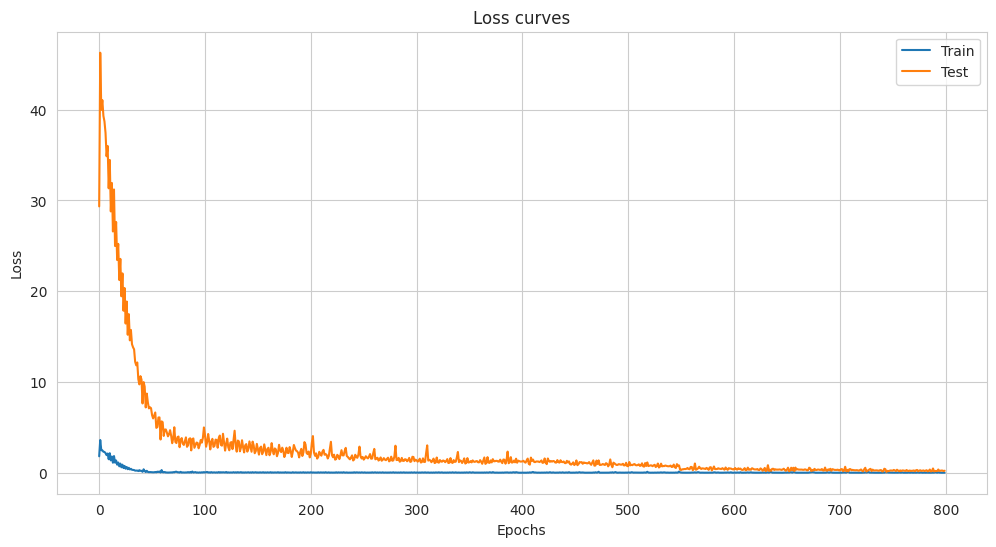

In [244]:
plot_losses(apple_lstm_results)

**Plotting the Predictions**

In [31]:
apple_lstm_model.load_state_dict(torch.load('apple_lstm_model.pth', weights_only=False))

<All keys matched successfully>

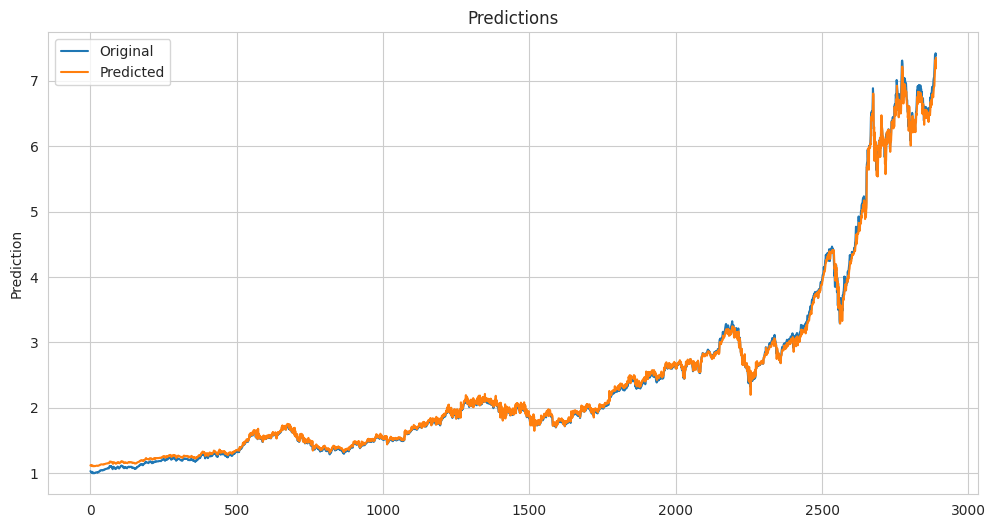

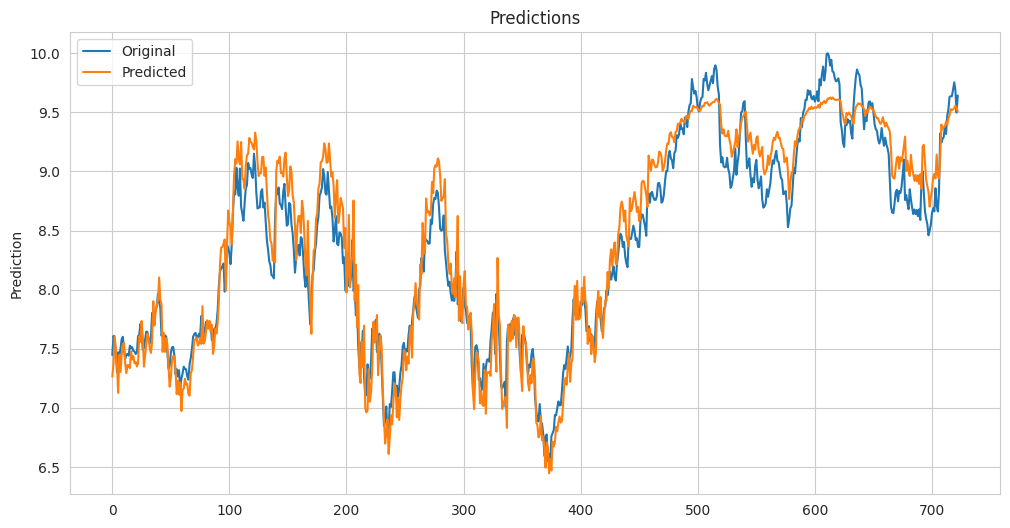

In [32]:
apple_lstm_model.eval()
with torch.no_grad():    
    train_predictions = apple_lstm_model(X_train_tensor)
    test_predictions = apple_lstm_model(X_test_tensor)


plot_predictions(y_train, train_predictions.cpu().numpy())
plot_predictions(y_test, test_predictions.cpu().numpy())


#### XGBoost

In [263]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Reshape the data for XGBoost
X_train_xgb = X_train.reshape(X_train.shape[0], -1)
X_test_xgb = X_test.reshape(X_test.shape[0], -1)

print(X_train_xgb.shape, X_test_xgb.shape)
# Create and train the XGBoost regressor
apple_xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000)
apple_train_preds, apple_test_preds = xgb_train(apple_xgb_model, X_train_xgb,
                                                y_train, X_test_xgb, y_test)


(2890, 10) (723, 10)
Train RMSE: 0.0036866761583714577, Test RMSE: 1.4479019335277454


#### Plotting the predictions

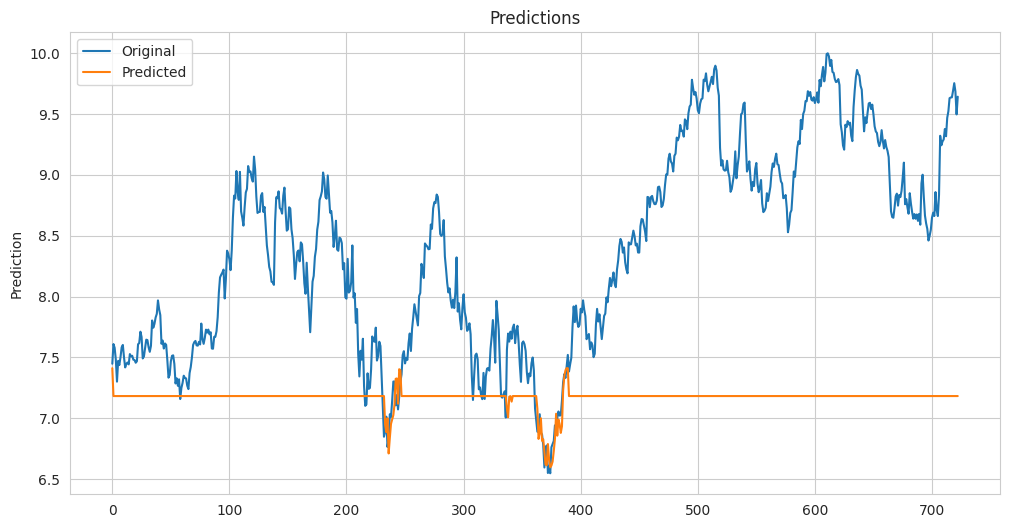

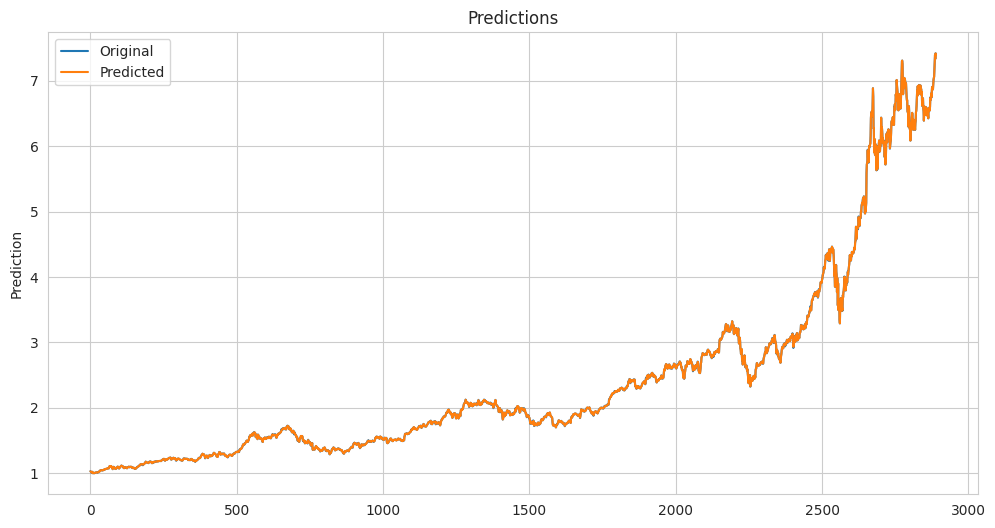

In [264]:
plot_predictions(y_test, apple_test_preds)
plot_predictions(y_train, apple_train_preds)

#### Predictions

In [268]:
apple_data['adj_close'].iloc[-30:-20].to_numpy()

array([172.456085, 169.150574, 167.772446, 166.813736, 164.776505,
       165.615356, 166.67392 , 168.791061, 169.659882, 169.070679])

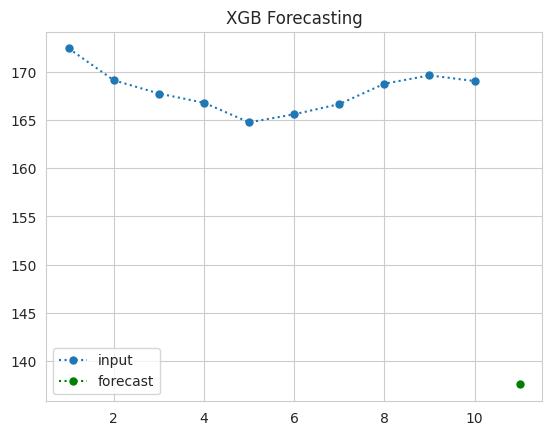

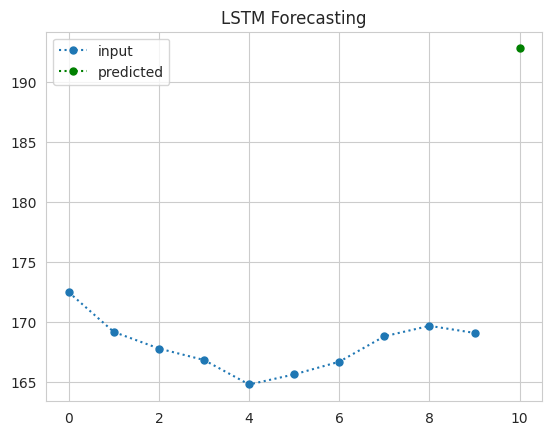

In [265]:
xgb_forecast(apple_xgb_model, 
            apple_data['adj_close_scaled'].iloc[-30:-20].to_numpy(), 
            apple_close_scaler)

lstm_forecast(apple_lstm_model, 
              apple_data['adj_close_scaled'].iloc[-30:-20].to_numpy(), 
              apple_close_scaler)

#### Saving the results

In [255]:
torch.save(apple_lstm_model.state_dict(), 'apple_lstm_model.pth')
joblib.dump(apple_close_scaler, 'apple_close_scaler.joblib')
joblib.dump(apple_xgb_model, 'apple_xgb_model.joblib')
apple_lstm_results.to_csv('apple_lstm_results.csv')

## Super Store Sales Forecasting

### Loading the data

In [44]:
store_df = pd.read_csv(store_path)
store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9800 non-null   int64  
 1   Order ID       9800 non-null   object 
 2   Order Date     9800 non-null   object 
 3   Ship Date      9800 non-null   object 
 4   Ship Mode      9800 non-null   object 
 5   Customer ID    9800 non-null   object 
 6   Customer Name  9800 non-null   object 
 7   Segment        9800 non-null   object 
 8   Country        9800 non-null   object 
 9   City           9800 non-null   object 
 10  State          9800 non-null   object 
 11  Postal Code    9789 non-null   float64
 12  Region         9800 non-null   object 
 13  Product ID     9800 non-null   object 
 14  Category       9800 non-null   object 
 15  Sub-Category   9800 non-null   object 
 16  Product Name   9800 non-null   object 
 17  Sales          9800 non-null   float64
dtypes: float

In [45]:
store_df.head()

Row ID        Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
0       1  CA-2017-152156  08/11/2017  11/11/2017    Second Class    CG-12520   
1       2  CA-2017-152156  08/11/2017  11/11/2017    Second Class    CG-12520   
2       3  CA-2017-138688  12/06/2017  16/06/2017    Second Class    DV-13045   
3       4  US-2016-108966  11/10/2016  18/10/2016  Standard Class    SO-20335   
4       5  US-2016-108966  11/10/2016  18/10/2016  Standard Class    SO-20335   

     Customer Name    Segment        Country             City       State  \
0      Claire Gute   Consumer  United States        Henderson    Kentucky   
1      Claire Gute   Consumer  United States        Henderson    Kentucky   
2  Darrin Van Huff  Corporate  United States      Los Angeles  California   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale     Florida   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale     Florida   

   Postal Code Region       Product ID         Category Sub-Category  \
0      42420.0  South  FUR-BO-10001798        Furniture    Bookcases   
1      42420.0  South  FUR-CH-10000454        Furniture       Chairs   
2      90036.0   West  OFF-LA-10000240  Office Supplies       Labels   
3      33311.0  South  FUR-TA-10000577        Furniture       Tables   
4      33311.0  South  OFF-ST-10000760  Office Supplies      Storage   

                                        Product Name     Sales  
0                  Bush Somerset Collection Bookcase  261.9600  
1  Hon Deluxe Fabric Upholstered Stacking Chairs,...  731.9400  
2  Self-Adhesive Address Labels for Typewriters b...   14.6200  
3      Bretford CR4500 Series Slim Rectangular Table  957.5775  
4                     Eldon Fold 'N Roll Cart System   22.3680

In [46]:

store_df['Order Date'] = pd.to_datetime(store_df['Order Date'],
                                        format="%d/%m/%Y")
store_df['Ship Date'] = pd.to_datetime(store_df['Ship Date'],
                                       format="%d/%m/%Y")

store_df['Ship Mode'] = store_df['Ship Mode'].astype('category')
store_df['Segment'] = store_df['Segment'].astype('category')
store_df['Category'] = store_df['Category'].astype('category')
store_df['Sub-Category'] = store_df['Sub-Category'].astype('category')
store_df['Region'] = store_df['Region'].astype('category')

store_df.drop(columns = ['Customer Name', 'Product Name'], inplace=True)


In [47]:
store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Row ID        9800 non-null   int64         
 1   Order ID      9800 non-null   object        
 2   Order Date    9800 non-null   datetime64[ns]
 3   Ship Date     9800 non-null   datetime64[ns]
 4   Ship Mode     9800 non-null   category      
 5   Customer ID   9800 non-null   object        
 6   Segment       9800 non-null   category      
 7   Country       9800 non-null   object        
 8   City          9800 non-null   object        
 9   State         9800 non-null   object        
 10  Postal Code   9789 non-null   float64       
 11  Region        9800 non-null   category      
 12  Product ID    9800 non-null   object        
 13  Category      9800 non-null   category      
 14  Sub-Category  9800 non-null   category      
 15  Sales         9800 non-null   float64 

In [49]:
store_df['Order Date'].describe()

count                             9800
mean     2017-05-01 05:13:51.673469440
min                2015-01-03 00:00:00
25%                2016-05-24 00:00:00
50%                2017-06-26 00:00:00
75%                2018-05-15 00:00:00
max                2018-12-30 00:00:00
Name: Order Date, dtype: object

### Data Visualization

In [273]:
avg_sales = store_df.groupby(
    by='Order Date')['Sales'].apply(lambda x: st.trim_mean(x, 0.1)).reset_index().rename(
    columns={'Order Date': 'date', 'Sales': 'sales'}
)

In [274]:
is_stationary(avg_sales['sales'])

True

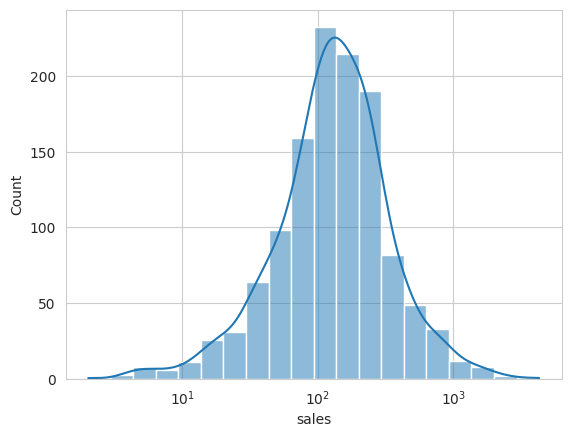

In [275]:
sns.histplot(data=avg_sales, x='sales', 
             bins=20, log_scale=True, kde=True)
plt.show()

In [276]:
avg_sales['sales_log'] = np.log(avg_sales['sales'])
avg_sales['sales_log'] = iqr_outliers(avg_sales['sales_log'])

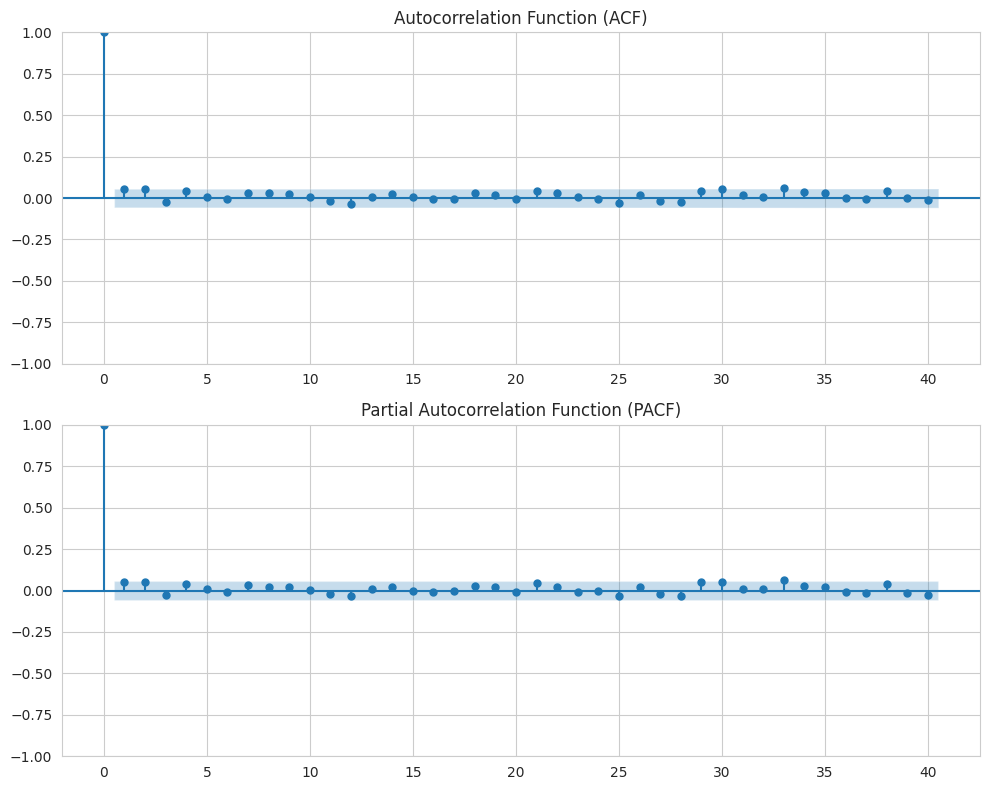

In [277]:
plot_acf_pacf(avg_sales['sales_log'])

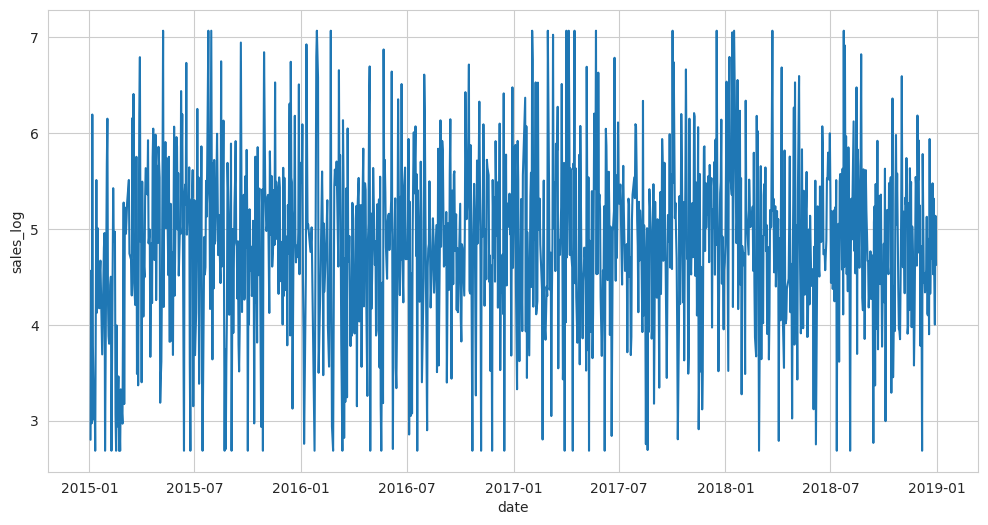

In [278]:
plt.figure(figsize=(12,6))
sns.lineplot(data=avg_sales, x='date', y='sales_log')
plt.show()

### Model Building

#### ARIMA

In [279]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Split data into training and testing sets
train_data = avg_sales['sales_log'][:-30]
test_data = avg_sales['sales_log'][-30:]


p = 30
q = 0
d = 1
sales_model = ARIMA(train_data, order=(p, d, q))
sales_model_fit = sales_model.fit()

# predictions on the test set
predictions = sales_model_fit.predict(start=len(train_data), 
                                      end=len(avg_sales['sales_log']) - 1)

# predict on training data
train_predictions = sales_model_fit.predict(start=0, end=len(train_data) - 1)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(test_data, predictions))

# train rmse
train_rmse = np.sqrt(mean_squared_error(train_data, train_predictions))

print('Train RMSE: %.3f' % train_rmse)
print('Test RMSE: %.3f' % rmse)

Train RMSE: 0.927
Test RMSE: 0.729


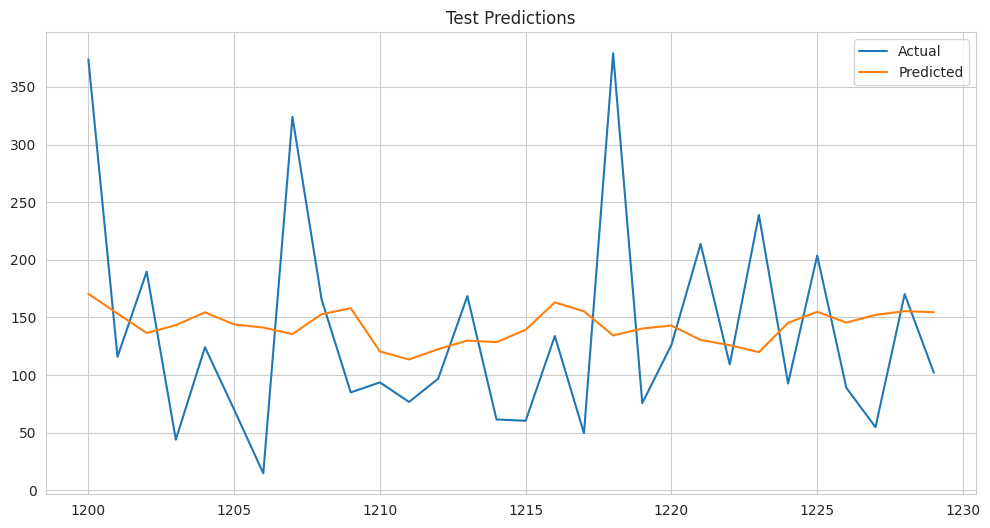

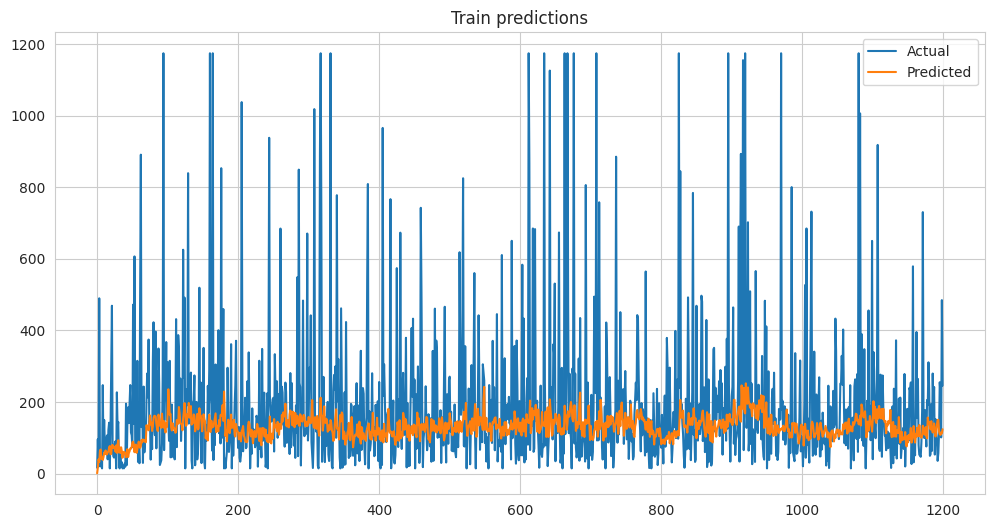

In [280]:
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, np.exp(test_data), label='Actual')
plt.plot(test_data.index, np.exp(predictions), label='Predicted')
plt.legend()
plt.title('Test Predictions')
plt.show()


plt.figure(figsize=(12, 6))
plt.plot(train_data.index, np.exp(train_data), label='Actual')
plt.plot(train_data.index, np.exp(train_predictions), label='Predicted')
plt.legend()
plt.title('Train predictions')
plt.show()


In [281]:
np.exp(train_data[-10:]).to_numpy()

array([115.02226667,  91.58707692,  35.712     ,  57.459     ,
       115.30245   , 255.18790909, 225.38371429, 101.21127273,
       484.5984    , 245.944     ])

In [282]:
np.exp(sales_model_fit.forecast(steps = 30))

1200    170.389525
1201    153.284560
1202    136.399358
1203    143.214131
1204    154.333609
1205    143.852177
1206    141.172092
1207    135.469436
1208    152.698096
1209    157.957522
1210    120.400146
1211    113.436375
1212    122.443121
1213    129.859534
1214    128.446124
1215    139.195925
1216    162.998326
1217    155.239958
1218    134.303491
1219    140.267791
1220    142.918664
1221    130.411039
1222    125.806427
1223    119.784543
1224    145.202870
1225    154.819889
1226    145.435597
1227    152.132255
1228    155.376068
1229    154.449519
Name: predicted_mean, dtype: float64

In [283]:
num_sales = store_df.groupby(by=['Order Date'])['Order ID'].count().reset_index().rename(
    columns = {'Order ID': 'num_sales', 'Order Date': 'date'}
)
num_sales.head()

date  num_sales
0 2015-01-03          1
1 2015-01-04          3
2 2015-01-05          1
3 2015-01-06          9
4 2015-01-07          2

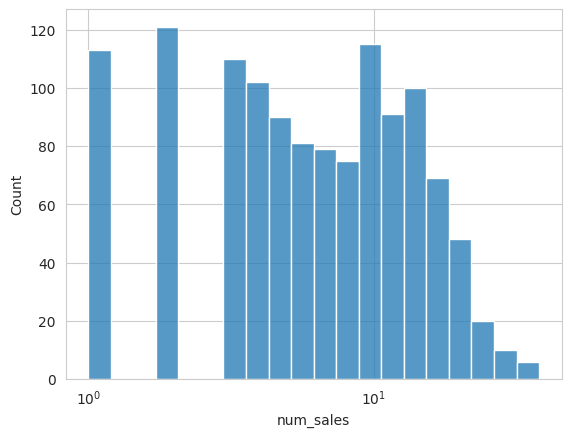

In [284]:
sns.histplot(data=num_sales, x='num_sales',
             log_scale=True, bins=20)
plt.show()

In [285]:
num_sales['num_sales_log'] = np.log(num_sales['num_sales'])
num_sales['num_sales_log'] = iqr_outliers(num_sales['num_sales_log'])

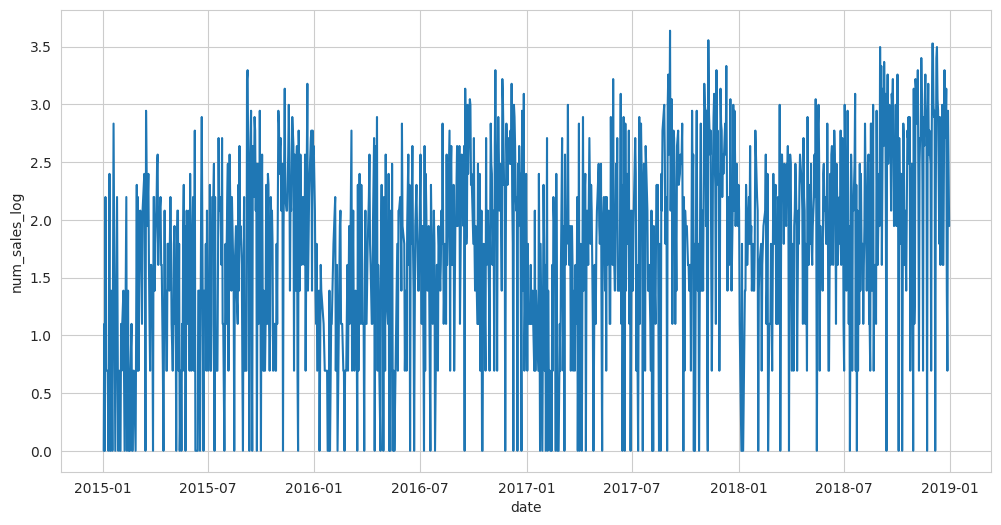

In [286]:
plt.figure(figsize=(12,6))
sns.lineplot(data=num_sales, x='date', y='num_sales_log')
plt.show()

In [287]:
is_stationary(num_sales['num_sales_log'])

True

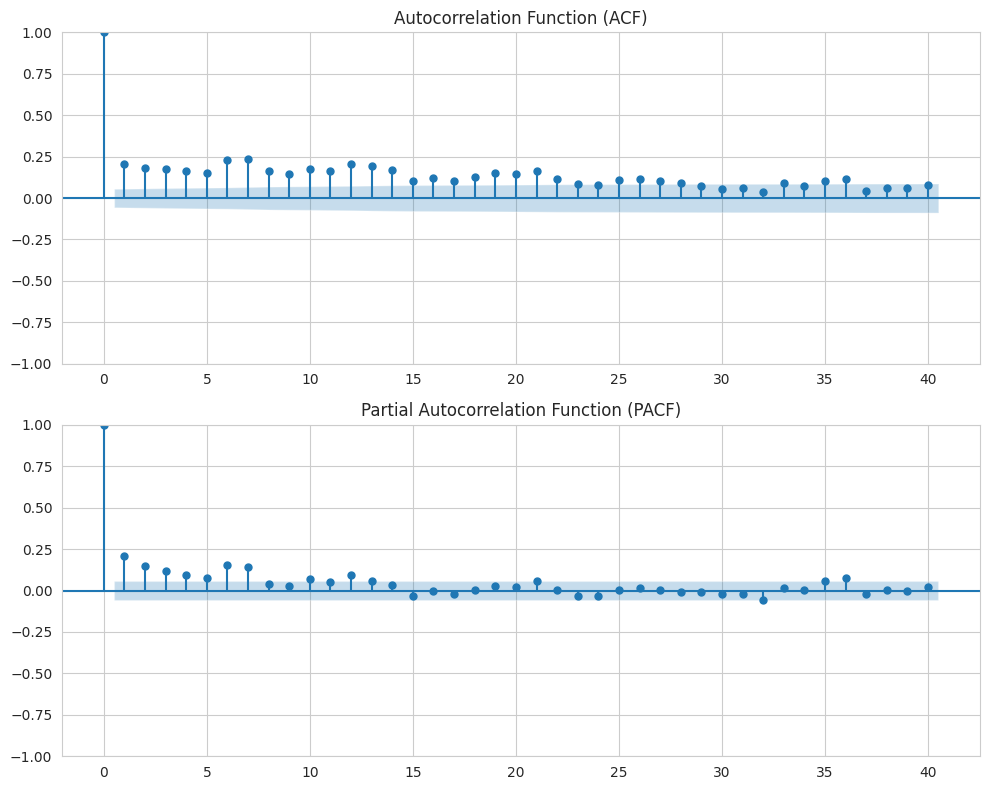

In [288]:
plot_acf_pacf(num_sales['num_sales_log'])

Train RMSE: 0.807
Test RMSE: 0.773


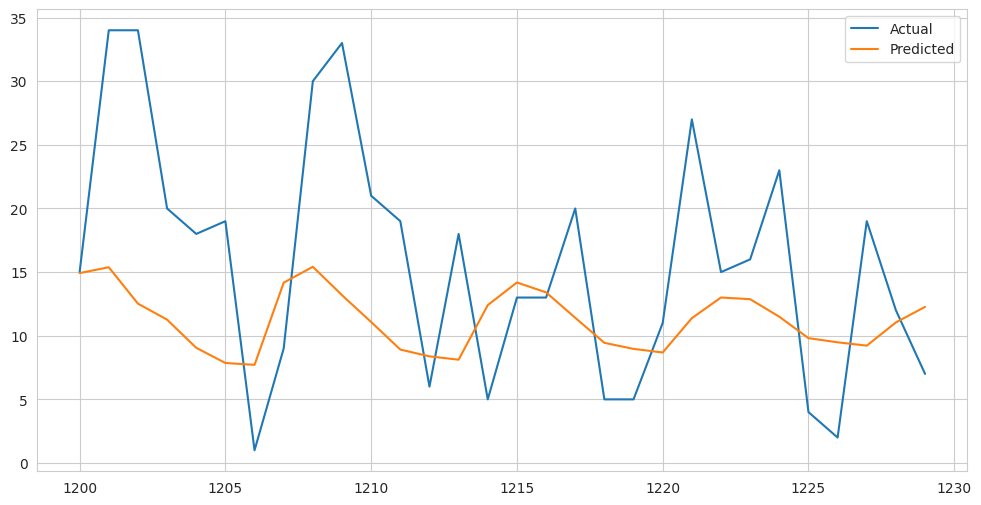

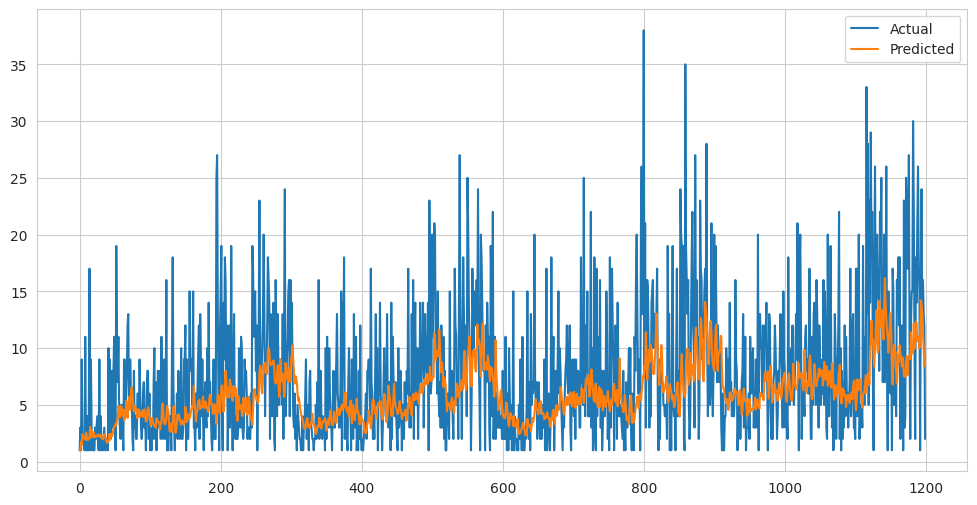

In [289]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

attr = 'num_sales_log'

# Split data into training and testing sets
train_data = num_sales[attr][:-30]
test_data = num_sales[attr][-30:]


p = 10
d = 1
q = 10
num_sales_model_arima = ARIMA(train_data, order=(p, d, q))
num_sales_model_arima_fit = num_sales_model_arima.fit()

# Make predictions on the test set
predictions = num_sales_model_arima_fit.predict(start=len(train_data), end=len(num_sales[attr]) - 1)

# predict on training data
train_predictions = num_sales_model_arima_fit.predict(start=0, end=len(train_data) - 1)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(test_data, predictions))

# train rmse
train_rmse = np.sqrt(mean_squared_error(train_data, train_predictions))

print('Train RMSE: %.3f' % train_rmse)
print('Test RMSE: %.3f' % rmse)

#Plot the predictions
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, np.exp(test_data), label='Actual')
plt.plot(test_data.index, np.exp(predictions), label='Predicted')
plt.legend()
plt.show()


# plot train predictions
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, np.exp(train_data), label='Actual')
plt.plot(train_data.index, np.exp(train_predictions), label='Predicted')
plt.legend()
plt.show()


In [290]:
np.exp(train_data[-10:].to_numpy())

array([17., 15.,  1., 17., 24., 13., 16., 13., 12.,  2.])

In [291]:
np.exp(num_sales_model_arima_fit.forecast(steps=20))

1200    14.921951
1201    15.380814
1202    12.523139
1203    11.262638
1204     9.052072
1205     7.857773
1206     7.712040
1207    14.170244
1208    15.418075
1209    13.187372
1210    11.077854
1211     8.913421
1212     8.379150
1213     8.118796
1214    12.405414
1215    14.184081
1216    13.407733
1217    11.410287
1218     9.441866
1219     8.965855
Name: predicted_mean, dtype: float64

Correlation between num_sales_log and avg_sales_log: 0.14945177169500684


Text(0, 0.5, 'sales_log')

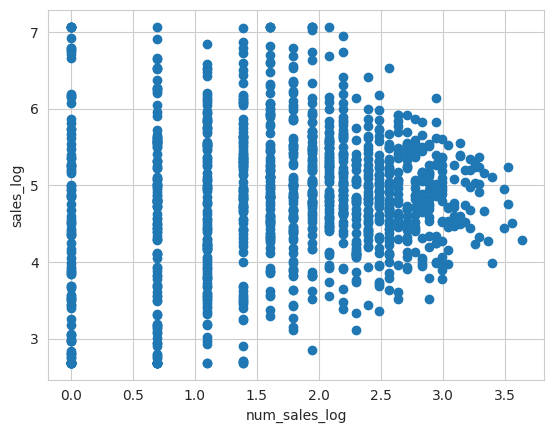

In [292]:

sales_df = pd.merge(num_sales, avg_sales, on='date', how='inner')

# Calculate the correlation
correlation = sales_df['num_sales_log'].corr(sales_df['sales_log'])
print(f"Correlation between num_sales_log and avg_sales_log: {correlation}")

# scatter plot
plt.scatter(sales_df['num_sales_log'], sales_df['sales_log'])
plt.xlabel('num_sales_log')
plt.ylabel('sales_log')

There isn't much correlation between number of sales and average sales

#### LSTM Model

In [293]:

sequence_length = 10
forecast_length = 1

sales_data = sales_df['num_sales_log'].values

X, y = create_sequences(sales_df, sequence_length, forecast_length, ['num_sales_log'], ['num_sales_log'])

y = np.squeeze(y, 1)
print("Sequences shape:", X.shape)
print("Targets shape:", y.shape)

Sequences shape: (1220, 10, 1)
Targets shape: (1220, 1)


In [294]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(976, 10, 1) (244, 10, 1) (976, 1) (244, 1)


In [295]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

print(X_train_tensor.shape, y_train_tensor.shape, X_test_tensor.shape, y_test_tensor.shape)

torch.Size([976, 10, 1]) torch.Size([976, 1]) torch.Size([244, 10, 1]) torch.Size([244, 1])


In [296]:

class SalesLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(SalesLSTMModel, self).__init__()

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Sequential(
             nn.ReLU(),
             nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out


input_size = 1
hidden_size = 10
num_layers = 1
output_size = 1

sales_lstm_model = SalesLSTMModel(input_size, hidden_size, 
                                  num_layers, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(sales_lstm_model.parameters(), lr=0.001)


In [297]:
num_sales_lstm_results = lstm_training(sales_lstm_model, 
                                       criterion, optimizer, 
                              X_train_tensor, y_train_tensor, 
                            X_test_tensor, y_test_tensor,
              batch_size =16, num_epochs = 200)

Epoch [1/200], Loss: 2.5256, Test Loss: 2.2414
Epoch [2/200], Loss: 1.4692, Test Loss: 1.1246
Epoch [3/200], Loss: 0.8905, Test Loss: 0.8329
Epoch [4/200], Loss: 0.7794, Test Loss: 0.7626
Epoch [5/200], Loss: 0.7629, Test Loss: 0.7460
Epoch [6/200], Loss: 0.7603, Test Loss: 0.7424
Epoch [7/200], Loss: 0.7589, Test Loss: 0.7421
Epoch [8/200], Loss: 0.7564, Test Loss: 0.7430
Epoch [9/200], Loss: 0.7491, Test Loss: 0.7563
Epoch [10/200], Loss: 0.7274, Test Loss: 0.7395
Epoch [11/200], Loss: 0.7235, Test Loss: 0.7193
Epoch [12/200], Loss: 0.7458, Test Loss: 0.9545
Epoch [13/200], Loss: 0.7346, Test Loss: 0.7328
Epoch [14/200], Loss: 0.7733, Test Loss: 0.7480
Epoch [15/200], Loss: 0.7293, Test Loss: 0.7447
Epoch [16/200], Loss: 0.7021, Test Loss: 0.7486
Epoch [17/200], Loss: 0.6794, Test Loss: 0.7220
Epoch [18/200], Loss: 0.6809, Test Loss: 0.7151
Epoch [19/200], Loss: 0.7798, Test Loss: 0.9450
Epoch [20/200], Loss: 0.8021, Test Loss: 0.7319
Epoch [21/200], Loss: 0.7458, Test Loss: 0.7601
E

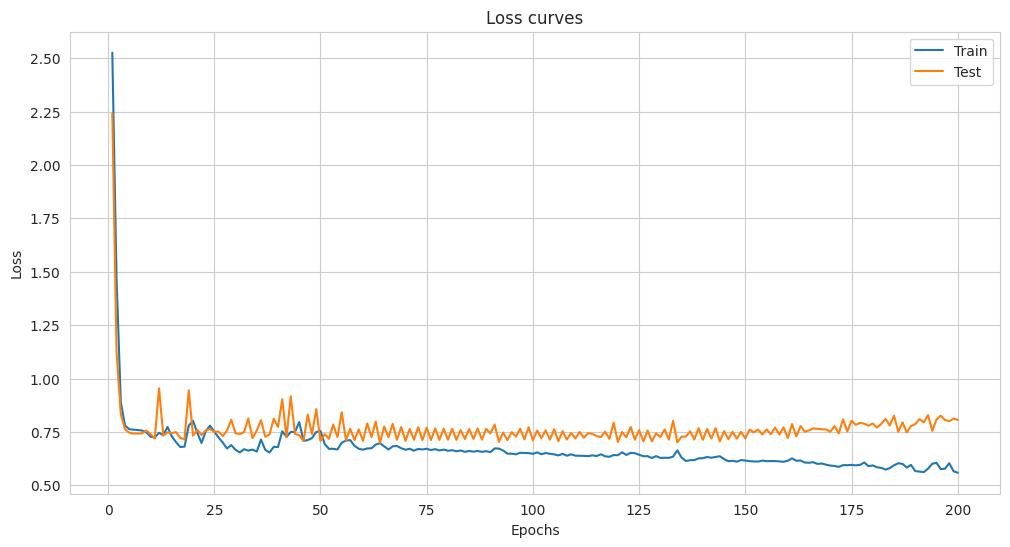

In [298]:
plot_losses(num_sales_lstm_results)

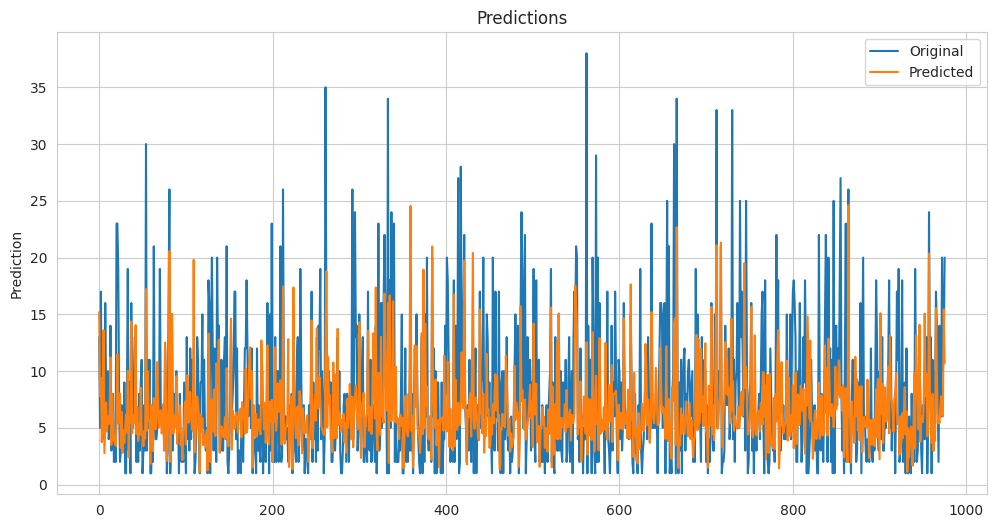

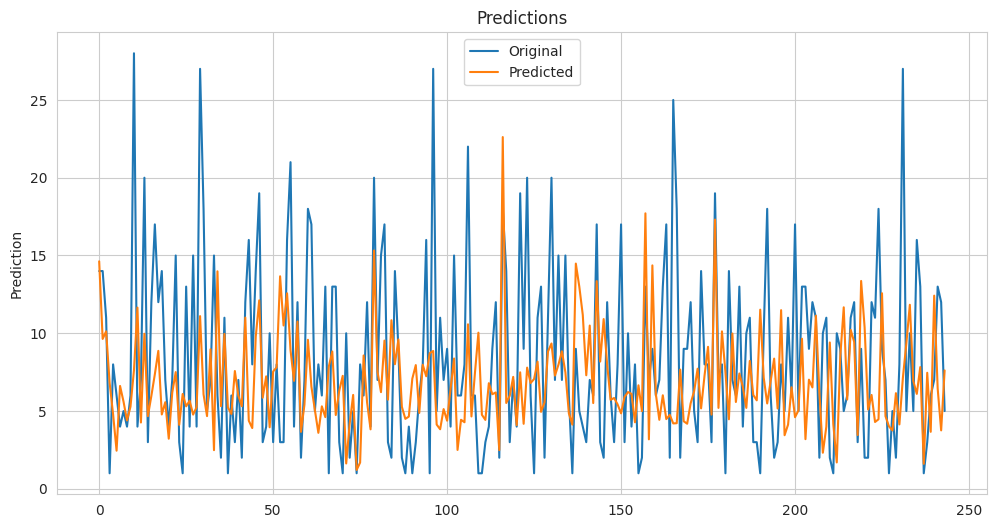

In [300]:
sales_lstm_model.eval()

with torch.no_grad():

  y_test_pred = sales_lstm_model(X_test_tensor).detach().numpy()
  y_train_pred = sales_lstm_model(X_train_tensor).detach().numpy()

plot_predictions(np.exp(y_train), np.exp(y_train_pred))
plot_predictions(np.exp(y_test), np.exp(y_test_pred))

### XGBoost Model

Train RMSE: 0.001782243930400121, Test RMSE: 0.8973835479145017


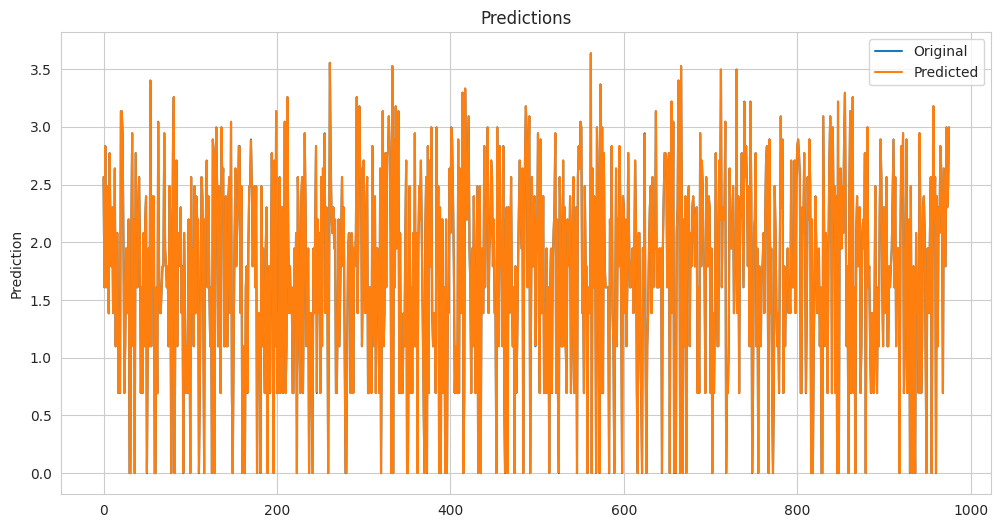

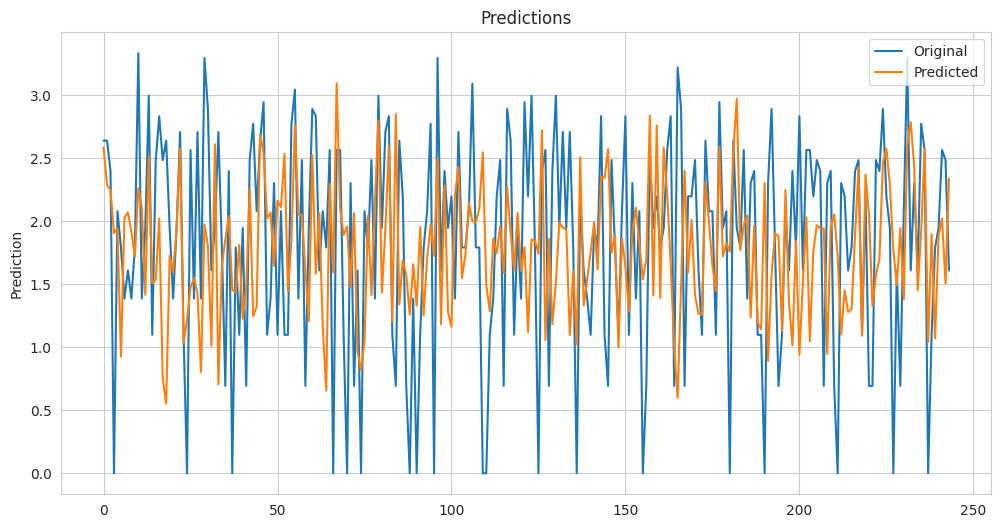

In [301]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Reshape the data for XGBoost
X_train_xgb = X_train.reshape(X_train.shape[0], -1)
X_test_xgb = X_test.reshape(X_test.shape[0], -1)

# Initialize the XGBoost regressor
num_sales_xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    random_state=42)

train_preds, test_preds = xgb_train(num_sales_xgb_model, X_train_xgb, y_train, X_test_xgb, y_test)


plot_predictions(y_train, train_preds)
plot_predictions(y_test, test_preds)


#### Predictions

In [302]:
inputs = sales_df['num_sales_log'].iloc[-20:-10].to_numpy()
np.exp(inputs)

array([21., 19.,  6., 18.,  5., 13., 13., 20.,  5.,  5.])

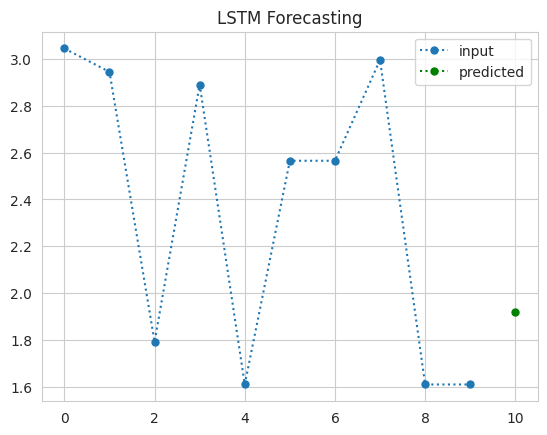

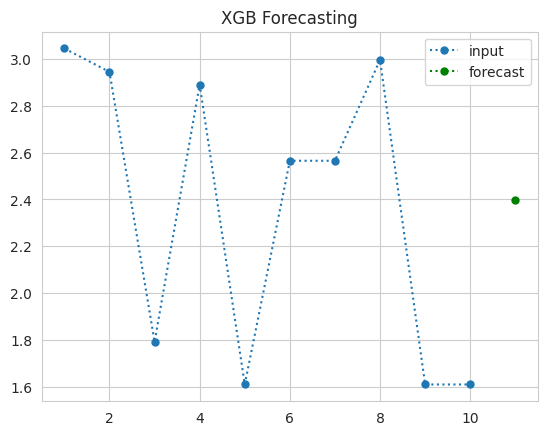

In [303]:
lstm_forecast(sales_lstm_model, inputs)
xgb_forecast(num_sales_xgb_model, inputs)

In [305]:
torch.save(sales_lstm_model.state_dict(), "sales_lstm_model.pth")
num_sales_lstm_results.to_csv('num_sales_lstm_results.csv', index=False)
joblib.dump(num_sales_xgb_model, "num_sales_xgb_model.joblib")
joblib.dump(num_sales_model_arima_fit, "num_sales_model_arima_fit.joblib")
joblib.dump(sales_model_fit, "sales_model_fit.joblib")

['sales_model_fit.joblib']

## Delhi Weather

### Reading Data

In [306]:
climate_path_test = os.path.join(climate_path, "DailyDelhiClimateTest.csv")
climate_path_train = os.path.join(climate_path, "DailyDelhiClimateTrain.csv")

climate_train_df = pd.read_csv(climate_path_train, 
                               parse_dates = ['date'],
                               index_col='date')
climate_test_df = pd.read_csv(climate_path_test,
                              parse_dates = ['date'],
                              index_col='date' )


climate_train_df.rename(columns = {'meantemp':'temp'} , inplace = True)
climate_test_df.rename(columns =  {'meantemp':'temp'} , inplace = True)

In [307]:
climate_train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1462 entries, 2013-01-01 to 2017-01-01
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   temp          1462 non-null   float64
 1   humidity      1462 non-null   float64
 2   wind_speed    1462 non-null   float64
 3   meanpressure  1462 non-null   float64
dtypes: float64(4)
memory usage: 57.1 KB


In [308]:
climate_test_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 114 entries, 2017-01-01 to 2017-04-24
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   temp          114 non-null    float64
 1   humidity      114 non-null    float64
 2   wind_speed    114 non-null    float64
 3   meanpressure  114 non-null    float64
dtypes: float64(4)
memory usage: 4.5 KB


### EDA

In [309]:
df_info = pd.concat([climate_train_df.isna().sum() , climate_train_df.dtypes] , axis = 1)
df_info.columns = ['missing'  , 'dtype']
df_info

missing    dtype
temp                0  float64
humidity            0  float64
wind_speed          0  float64
meanpressure        0  float64

In [310]:
# no duplicates
climate_train_df[climate_train_df.duplicated()].sum()

temp            0.0
humidity        0.0
wind_speed      0.0
meanpressure    0.0
dtype: float64

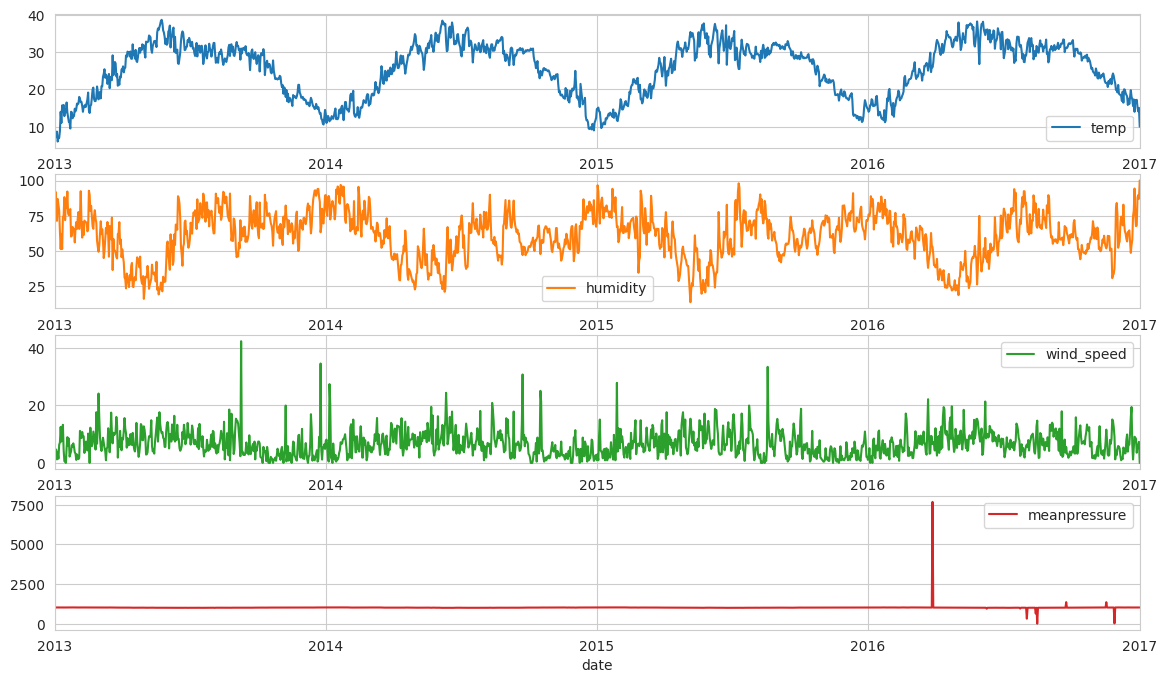

In [311]:
climate_train_df.plot(subplots = True,
           layout = (4,1),
           figsize = (14,8),
           sharex= False)

plt.show()

**it is obvious , there is yearly seasonal , and there is anomoly in mean pressure**

In [312]:
climate_train_df['meanpressure'].describe()

count    1462.000000
mean     1011.104548
std       180.231668
min        -3.041667
25%      1001.580357
50%      1008.563492
75%      1014.944901
max      7679.333333
Name: meanpressure, dtype: float64

**Typical atmospheric range is around: 965 to 1040**

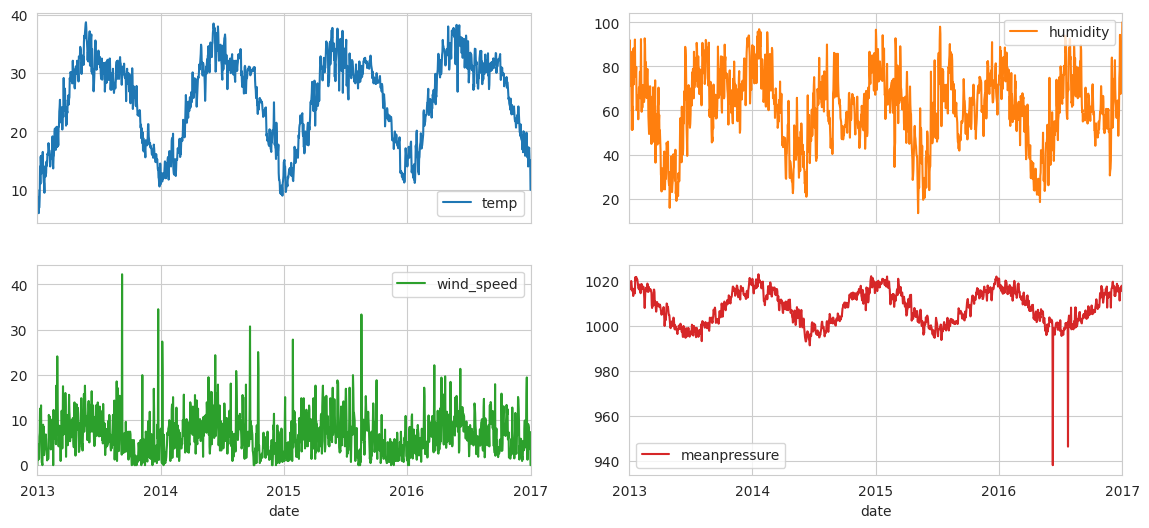

In [313]:
climate_train_errors = climate_train_df[(climate_train_df['meanpressure'] < 900) | (climate_train_df['meanpressure']>1083)]
train_cleaned = climate_train_df.drop(climate_train_errors.index , axis = 0)
mean_pressure_modified = train_cleaned['meanpressure'].mean()
climate_train_df.loc[climate_train_errors.index , 'meanpressure'] = mean_pressure_modified
climate_train_df.plot(subplots = True , layout = (2,2) , figsize = (14,6))
plt.show()

Text(0.5, 1.0, 'mean pressure after cleaning')

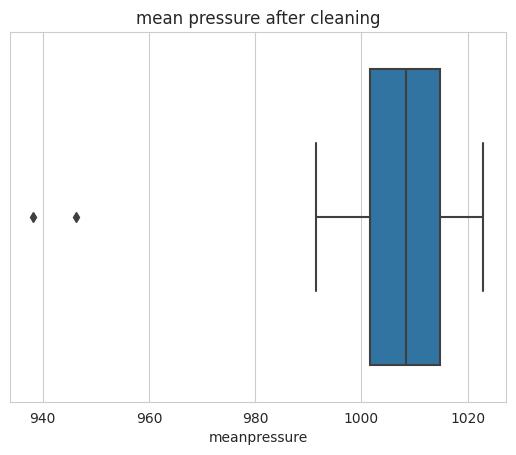

In [314]:
sns.boxplot(climate_train_df , x = 'meanpressure')
plt.title('mean pressure after cleaning')

In [315]:
train_weekly = climate_train_df.resample('W').mean()
train_monthly = climate_train_df.resample('ME').mean()

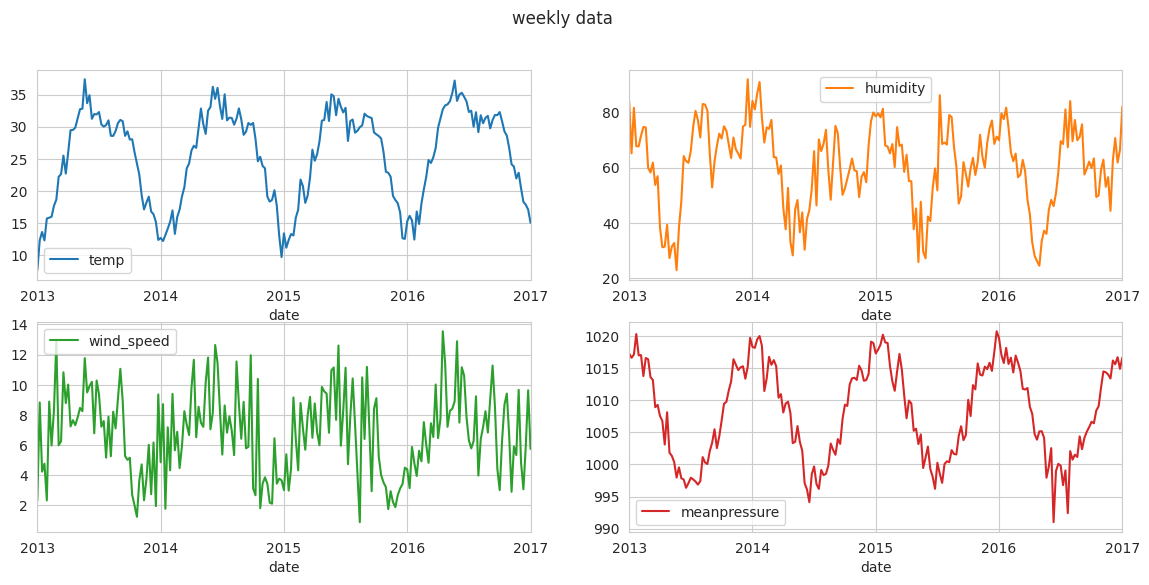

In [316]:
train_weekly.plot(subplots = True,
                  layout = (2,2),
                  figsize = (14,6),
                  title = 'weekly data',
                  sharex=False)

plt.show()

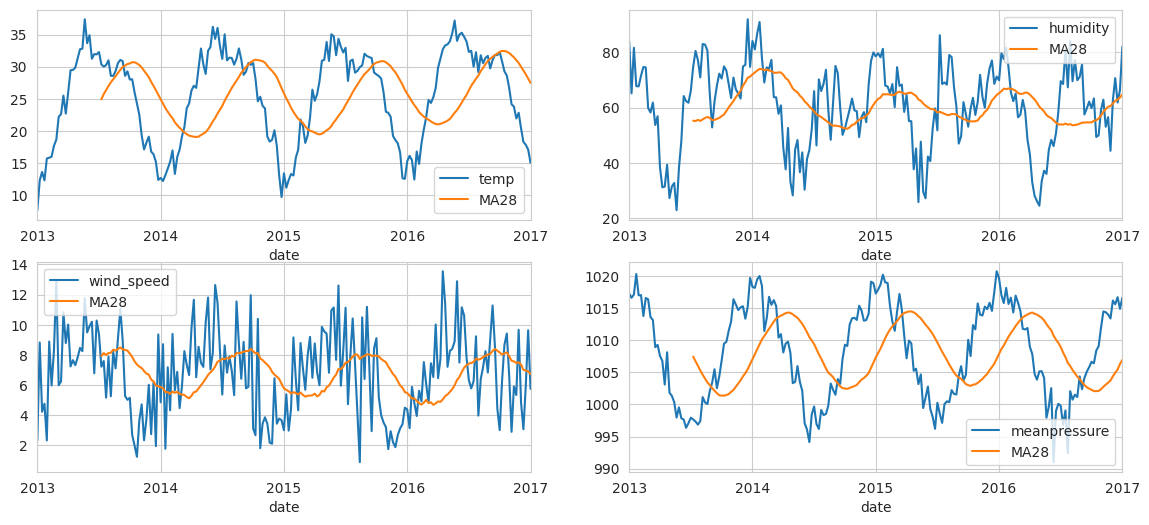

In [317]:
MA28 = train_weekly.rolling(window=28).mean()

fig , ax = plt.subplots(nrows = 2 , ncols=2 ,figsize = (14,6))

for ax , col in zip(ax.flat , climate_train_df.columns):
    train_weekly[col].plot(ax = ax , legend = col)
    MA28[col].plot(ax = ax  , label = 'MA28')
    ax.legend()

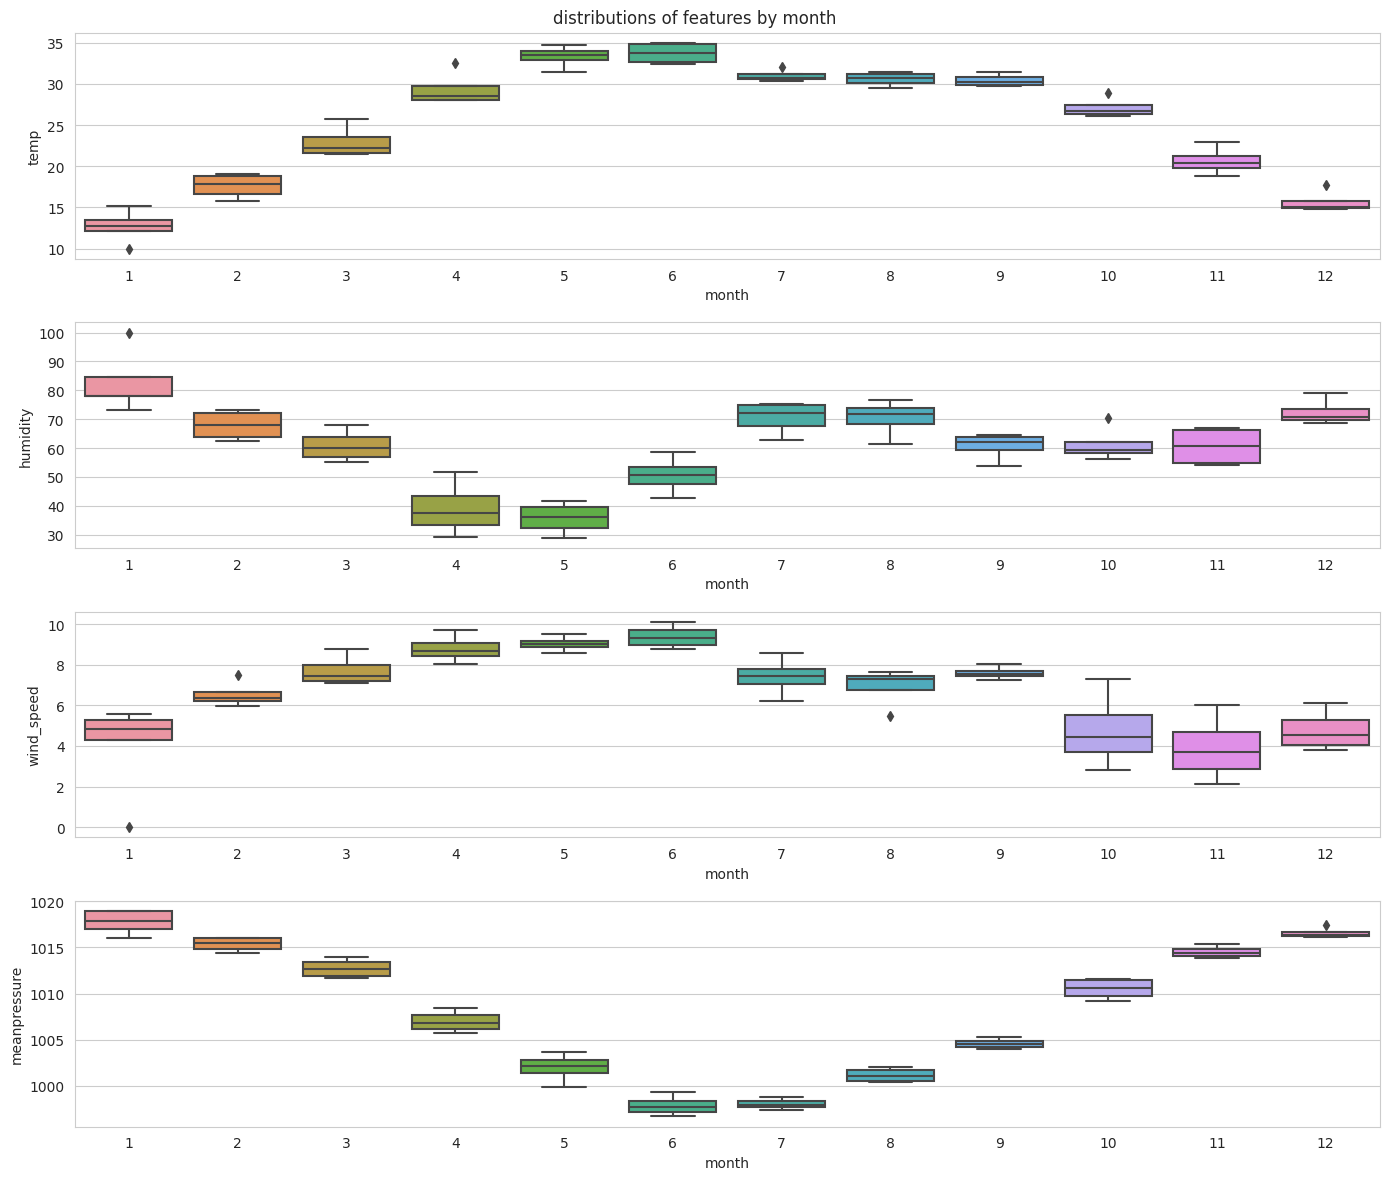

In [318]:
fig , ax = plt.subplots(4,1,figsize = (14,12) )

for ax , col in zip(ax.flat , climate_train_df.columns):
    sns.boxplot(train_monthly , y = col , 
                x=train_monthly.index.month,ax = ax)
    ax.set_xlabel('month')

fig.suptitle('distributions of features by month') , plt.tight_layout()
plt.show()

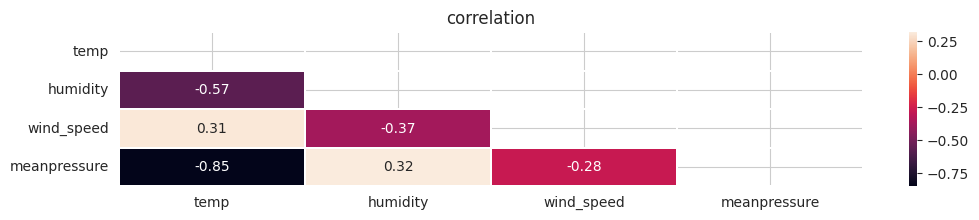

In [319]:
train_corr = climate_train_df.corr()
mask = np.tril(np.ones(train_corr.shape) , k = -1).astype(bool)
train_corr = train_corr.where(mask)


plt.figure(figsize = (12,2))
sns.heatmap(train_corr , annot =True ,linewidths=0.1) , plt.title('correlation')
plt.show()

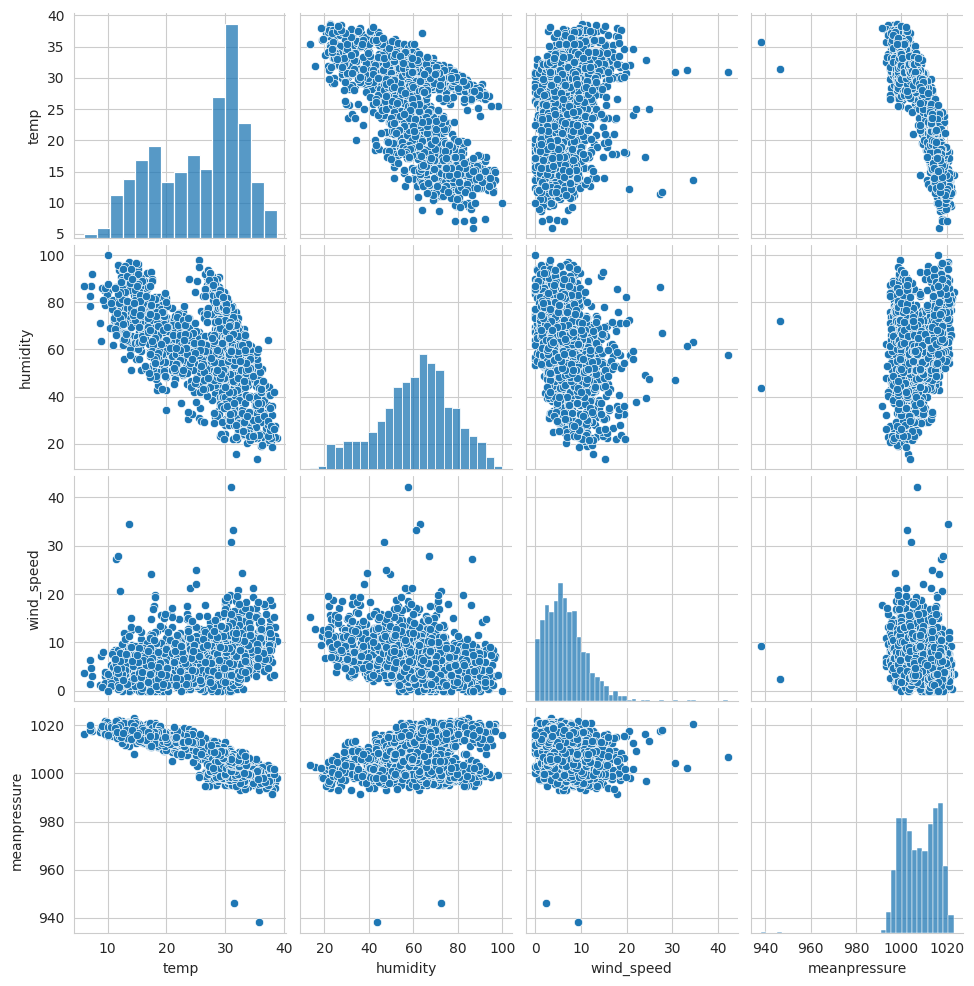

In [320]:
sns.pairplot(climate_train_df)
plt.show()

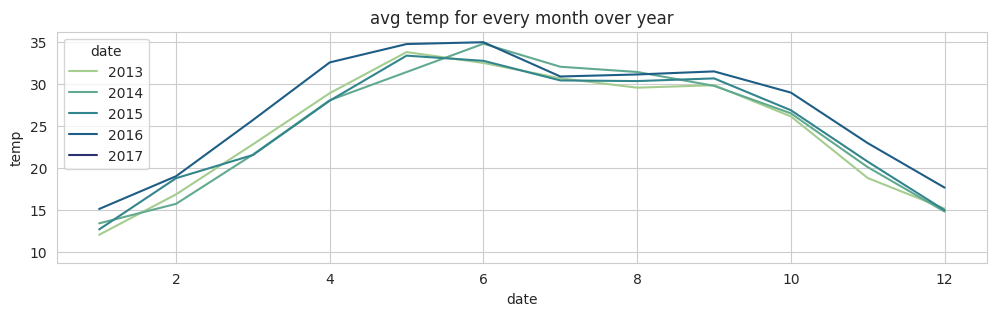

In [321]:
plt.figure(figsize = (12,3))
sns.lineplot(climate_train_df ,x = climate_train_df.index.month ,
             y = 'temp',
             hue = climate_train_df.index.year ,
             palette='crest' , errorbar = None)
plt.title('avg temp for every month over year')
plt.show()

<Figure size 1400x600 with 0 Axes>

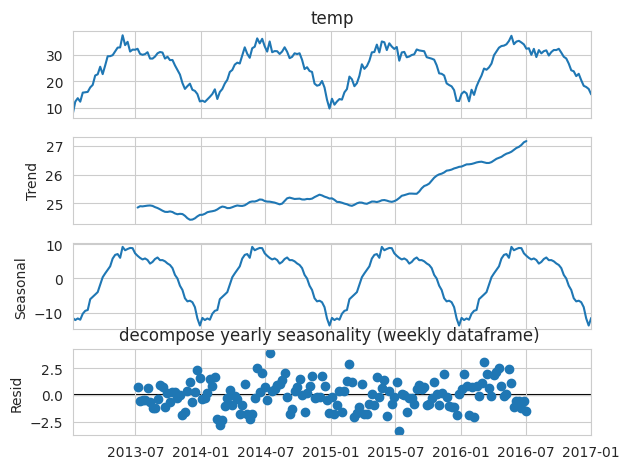

In [322]:
plt.figure(figsize=(14,6))
decompose_temp = sm.tsa.seasonal_decompose(train_weekly['temp'])
decompose_temp.plot()
plt.title('decompose yearly seasonality (weekly dataframe) ')

plt.show()

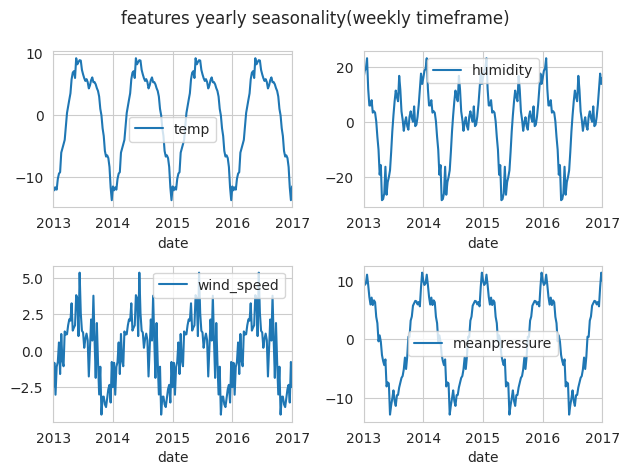

In [323]:
fig ,ax = plt.subplots(2,2)
for ax , col in zip(ax.flat , climate_train_df.columns):
    decompose= sm.tsa.seasonal_decompose(train_weekly[col])
    decompose.seasonal.plot(ax = ax , label = col)
    ax.legend()
    plt.tight_layout()
    plt.suptitle('features yearly seasonality(weekly timeframe)')

there is yearly seasonality for all feature ,wind speed seasonality is more noisier
check for weekly seasonality
important : we need to take smaller observation period, lets take 6 month we do this , because for all data , we can not visulize daily timeframe

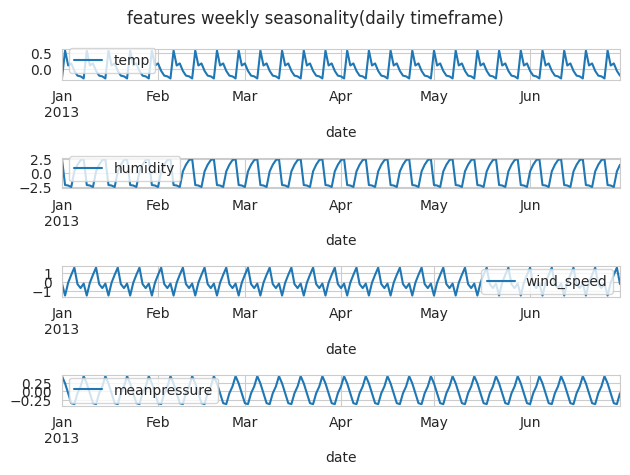

In [324]:
period = slice( '2013-01' ,'2013-06' )   # 6 month

fig ,ax = plt.subplots(4,1)    # order of subplots changed , to see wider observation
for ax , col in zip(ax.flat , climate_train_df.columns):
    decompose= sm.tsa.seasonal_decompose(climate_train_df[period][col])   # notice , it is daily data for 6 month
    decompose.seasonal.plot(ax = ax , label = col)
    ax.legend()
    plt.tight_layout()
    plt.suptitle('features weekly seasonality(daily timeframe)')

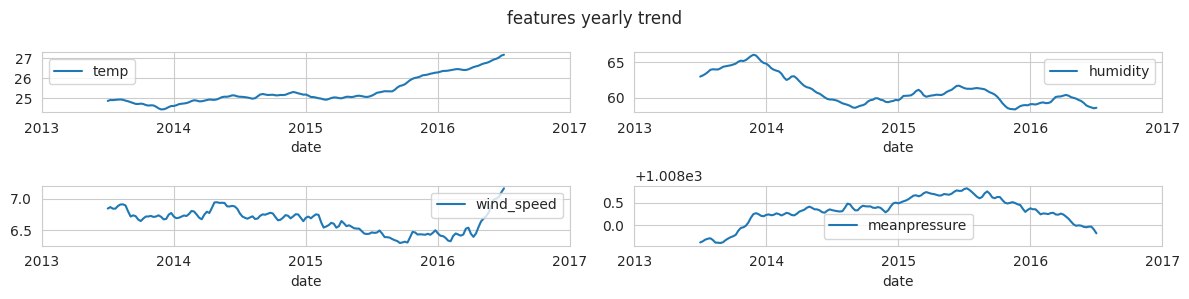

In [325]:
fig ,ax = plt.subplots(2,2 , figsize = (12,3))

for ax , col in zip(ax.flat , climate_train_df.columns):
    decompose= sm.tsa.seasonal_decompose(train_weekly[col])
    decompose.trend.plot(ax = ax , label = col)
    ax.legend()
    plt.tight_layout()
    plt.suptitle('features yearly trend')

### Model Building

In [326]:
from sklearn.preprocessing import StandardScaler

df_train = climate_train_df.copy(deep=True)
df_test = climate_test_df.copy(deep=True)
# df_val = climate_train_df['2016-06':].copy(deep=True) 
# almost 15% of train data set as validation set

climate_scaler = StandardScaler()
climate_scaler.fit(df_train[['temp']])
df_train['temp'] = climate_scaler.transform(df_train[['temp']])
# df_val['temp'] = climate_scaler.transform(df_val['temp'])
df_test['temp'] = climate_scaler.transform(df_test[['temp']])

seq_length = 10
forecast_length = 1
# features = ['temp','meanpressure','wind_speed','humidity']
features = ['temp']
target_attrs = ['temp']

X_train, y_train = create_sequences(df_train, seq_length,
                                    forecast_length,
                                    features,
                                    target_attrs)

# X_val, y_val = create_sequences(df_val, seq_length,
#                                 forecast_length, 
#                                 features,
#                                 target_attrs)

X_test, y_test = create_sequences(df_test, seq_length,
                                  forecast_length, features,
                                  target_attrs)


y_train = np.squeeze(y_train, 1)
# y_val = np.squeeze(y_val, 1)
y_test = np.squeeze(y_test, 1)


# print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)
print(X_train.shape, y_train.shape)


X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
# X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
# y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

print(X_train_tensor.shape, 
      y_train_tensor.shape,
      # X_val_tensor.shape,
      # y_val_tensor.shape,
      X_test_tensor.shape,
      y_test_tensor.shape)


(1452, 10, 1) (1452, 1)
torch.Size([1452, 10, 1]) torch.Size([1452, 1]) torch.Size([104, 10, 1]) torch.Size([104, 1])


In [327]:
class ClimateModel(nn.Module):

  def __init__(self, input_size, hidden_size, output_size, num_layers):
    super(ClimateModel, self).__init__()
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
    self.linear = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    lstm_out, _ = self.lstm(x)
    out = self.linear(lstm_out[:, -1, :])
    return out

In [338]:
input_size = 1
hidden_size = 8
num_layers = 1
output_size= 1
learning_rate = 0.001
batch_size = 16
num_epochs = 300
climate_model = ClimateModel(input_size=input_size,
                  hidden_size=hidden_size,
                  output_size = output_size,
                  num_layers=num_layers).to(device)

criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(climate_model.parameters(), lr=learning_rate)

climate_model

ClimateModel(
  (lstm): LSTM(1, 8, batch_first=True)
  (linear): Linear(in_features=8, out_features=1, bias=True)
)

In [339]:
climate_results = lstm_training(climate_model,
              criterion,
              optimizer,
              X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, 
              batch_size, num_epochs)

Epoch [1/300], Loss: 0.7927, Test Loss: 0.3602
Epoch [2/300], Loss: 0.2668, Test Loss: 0.2054
Epoch [3/300], Loss: 0.1553, Test Loss: 0.1835
Epoch [4/300], Loss: 0.1567, Test Loss: 0.3961
Epoch [5/300], Loss: 0.1598, Test Loss: 0.1845
Epoch [6/300], Loss: 0.1441, Test Loss: 0.3305
Epoch [7/300], Loss: 0.1409, Test Loss: 0.1791
Epoch [8/300], Loss: 0.1505, Test Loss: 0.2642
Epoch [9/300], Loss: 0.1230, Test Loss: 0.1117
Epoch [10/300], Loss: 0.1122, Test Loss: 0.1886
Epoch [11/300], Loss: 0.0918, Test Loss: 0.1108
Epoch [12/300], Loss: 0.0993, Test Loss: 0.2373
Epoch [13/300], Loss: 0.0985, Test Loss: 0.1281
Epoch [14/300], Loss: 0.1069, Test Loss: 0.2200
Epoch [15/300], Loss: 0.0991, Test Loss: 0.1208
Epoch [16/300], Loss: 0.1064, Test Loss: 0.1956
Epoch [17/300], Loss: 0.1028, Test Loss: 0.1213
Epoch [18/300], Loss: 0.1099, Test Loss: 0.2056
Epoch [19/300], Loss: 0.1207, Test Loss: 0.1687
Epoch [20/300], Loss: 0.1468, Test Loss: 0.2237
Epoch [21/300], Loss: 0.1436, Test Loss: 0.0903
E

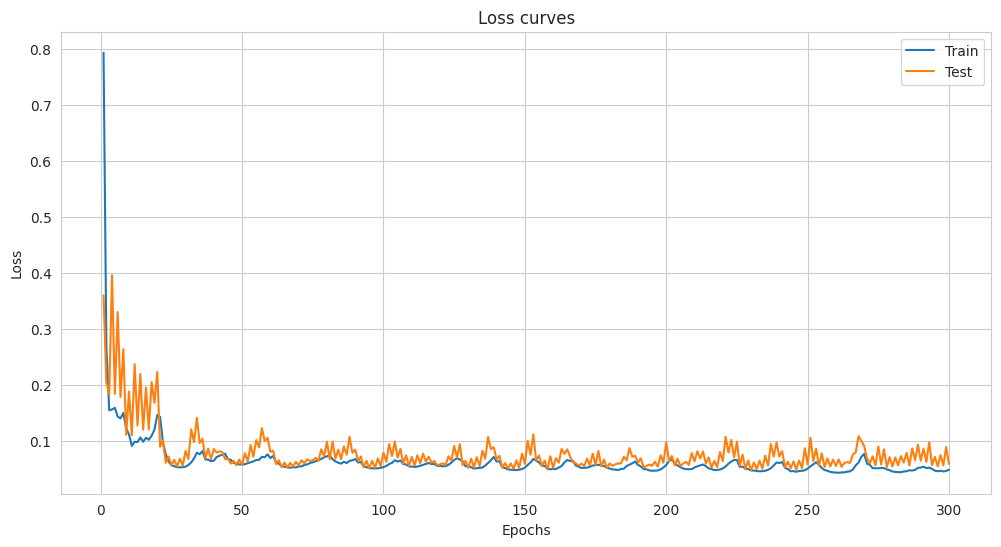

In [340]:
plot_losses(climate_results)

### Predictions

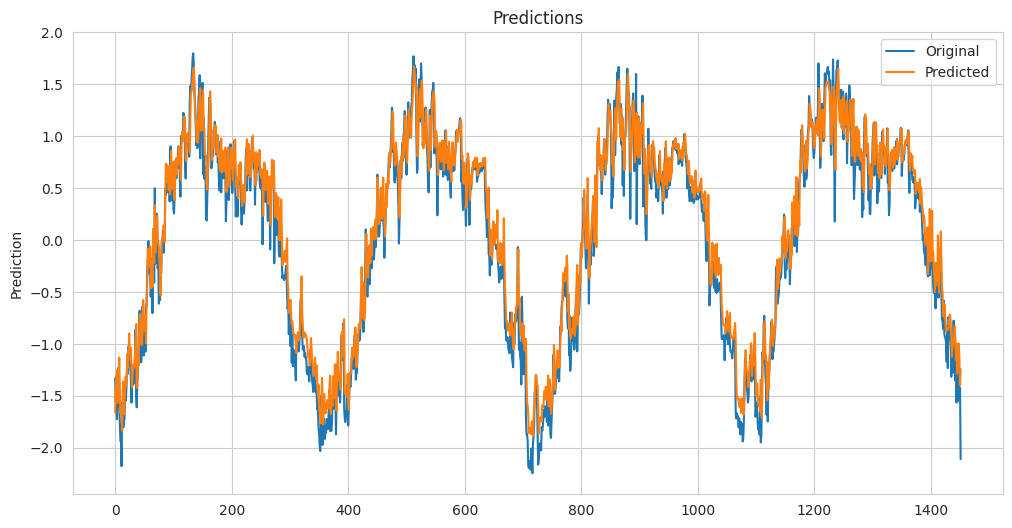

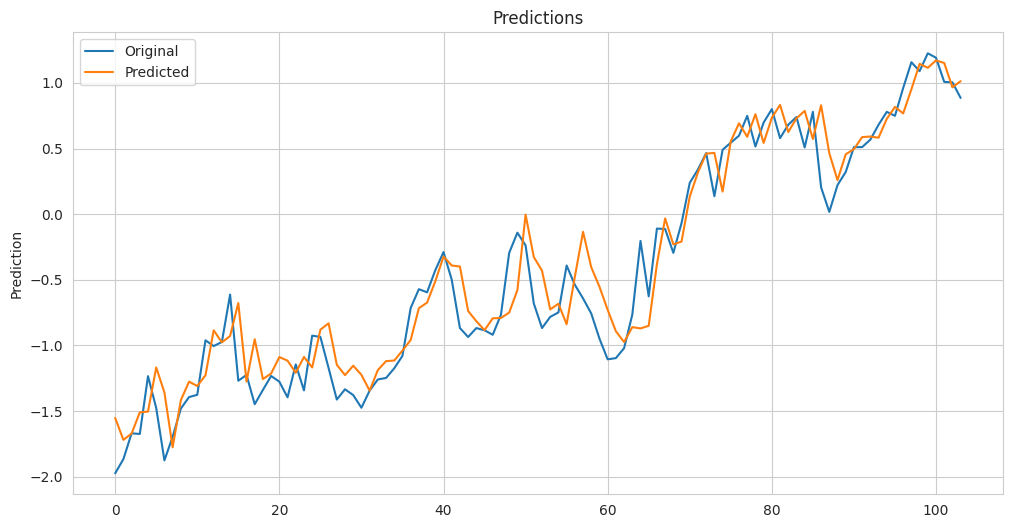

In [341]:
climate_model.eval()

with torch.no_grad():
    preds_train = climate_model(X_train_tensor).detach().cpu().numpy()
    # preds_val = climate_model(X_val_tensor).detach().cpu().numpy()
    preds_test = climate_model(X_test_tensor).detach().cpu().numpy()

plot_predictions(y_train, preds_train)
# plot_predictions(y_val, preds_val)
plot_predictions(y_test, preds_test)

In [ ]:
inputs.shape

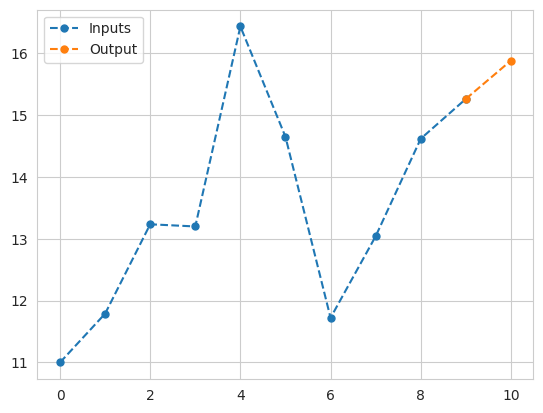

In [342]:
i = 10
    
inputs = climate_scaler.inverse_transform(X_test[i])
outputs = climate_scaler.inverse_transform([preds_test[i]])[0]


plt.plot(np.arange(10), inputs[:,0], label='Inputs',
         linestyle='--', marker='o', markersize=5)
plt.plot(np.arange(9,11), [inputs[:, 0][-1] ,outputs[0]], label='Output', 
         linestyle='--', marker='o', markersize=5)
    
plt.legend()
plt.show()

In [ ]:
inputs, outputs

### XGBoost Model

Train RMSE: 0.001709913548948332, Test RMSE: 0.25467041618136976


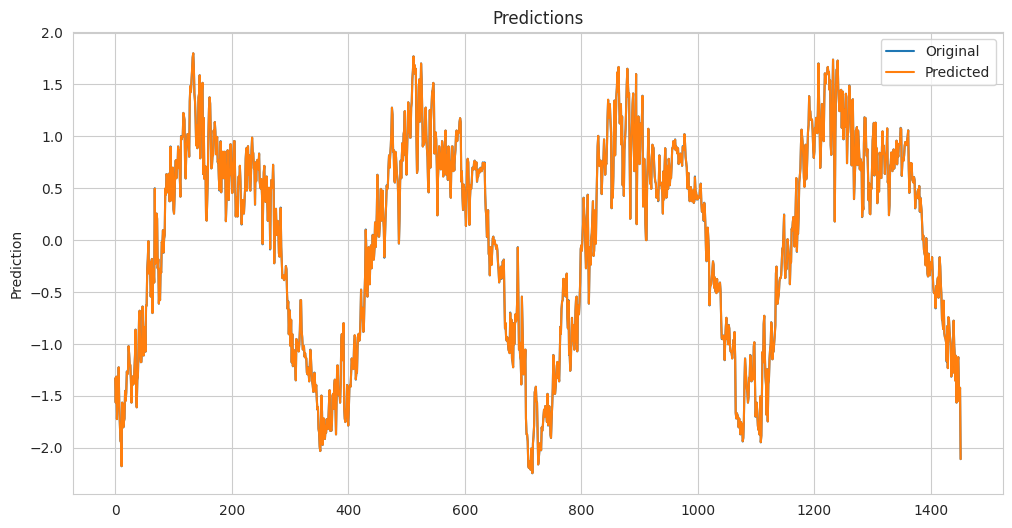

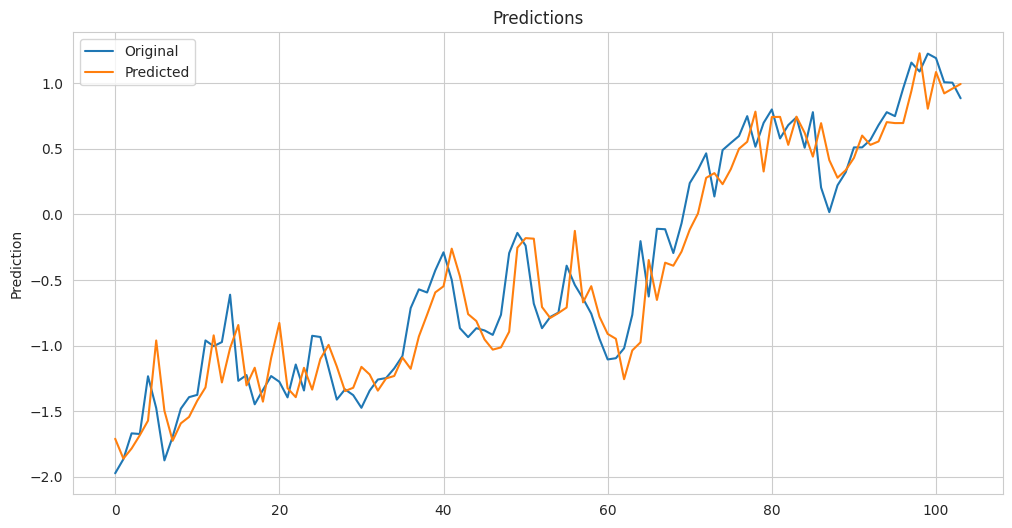

In [332]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Reshape the data for XGBoost
X_train_xgb = X_train.reshape(X_train.shape[0], -1)
# X_val_xgb = X_val.reshape(X_val.shape[0], -1)
X_test_xgb = X_test.reshape(X_test.shape[0], -1)
# Initialize the XGBoost regressor
climate_xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    random_state=42)

train_preds, test_preds = xgb_train(climate_xgb_model, X_train_xgb, y_train, 
                                   X_test_xgb, y_test)


plot_predictions(y_train, train_preds)
plot_predictions(y_test, test_preds)


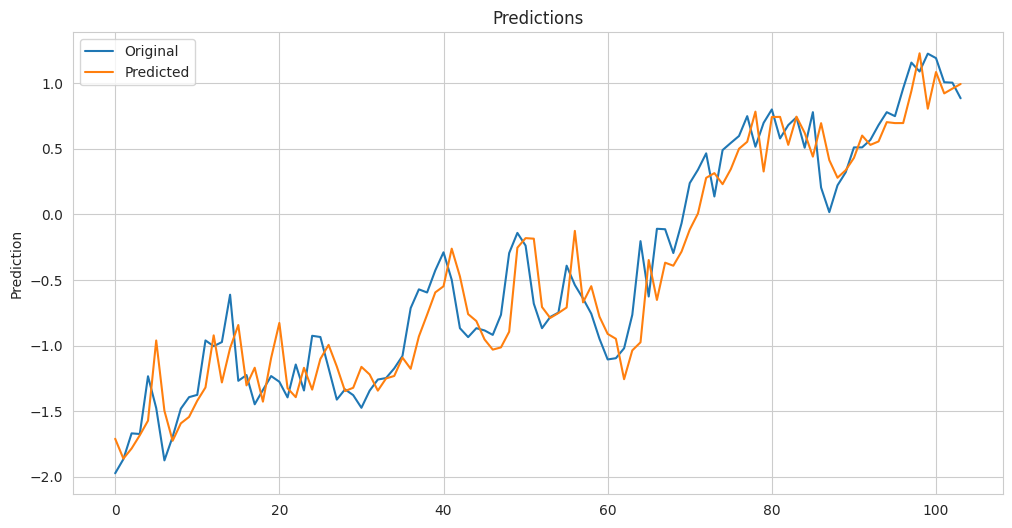

In [333]:
preds_test_xgb = climate_xgb_model.predict(X_test_xgb)
plot_predictions(y_test, preds_test_xgb)

In [346]:
inputs[:, 0]

array([11.        , 11.78947368, 13.23529412, 13.2       , 16.43478261,
       14.65      , 11.72222222, 13.04166667, 14.61904762, 15.26315789])

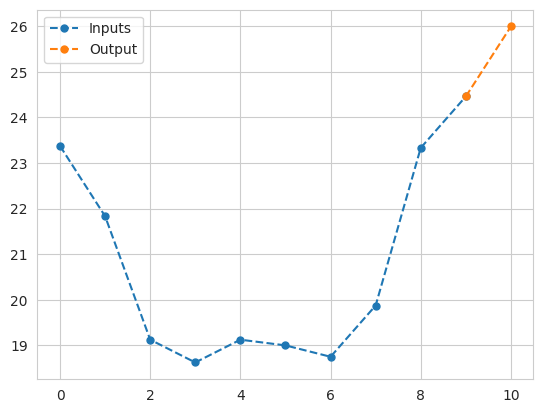

In [334]:
i = 50

inputs = climate_scaler.inverse_transform(X_test[i])[:, 0]
outputs = climate_scaler.inverse_transform([preds_test[i]])[0]


plt.plot(np.arange(10), inputs, label='Inputs', linestyle='--', 
         marker='o', markersize=5)
plt.plot(np.arange(9,11), [inputs[-1], outputs[0]], label='Output', 
         linestyle='--', 
         marker='o', markersize=5)
    
plt.legend()
plt.show()

### Saving the results

In [344]:
torch.save(climate_model.state_dict(), 'climate_model.pth')
joblib.dump(climate_xgb_model, "climate_xgb_model.joblib")
joblib.dump(climate_scaler, "climate_scaler.joblib")
climate_results.to_csv("climate_lstm_results.csv", index=False)